**Driver Behavior Classification**

Import Libraries

In [1]:
# To create file directories 
import os
import shutil
import random
import tqdm
import datetime
from pathlib import Path
import tkinter as tk
from tkinter import filedialog

import cv2
from cv2 import dnn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
 

# SKLearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Tensorflow
import tensorflow as tf

from tensorflow.keras.applications import MobileNet,MobileNetV2,VGG16, VGG19

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D,MaxPooling2D

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

#from tensorflow.keras.applications.mobilenet import preprocess_input

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

from tensorboard.plugins.hparams import api as hp

import warnings
warnings.filterwarnings("ignore")

---

Define Functions:

In [2]:
def writePath2File(path):
    # write the file path into text file under the current working directory
    dir_path,file = os.path.split(path)
    
    dest_path = os.path.join(os.getcwd(), file+'.txt')
    dest_path = Path(dest_path).as_posix()
    with open(dest_path, 'w') as f:
        f.write(path)

In [3]:
def readPathFromFile(filename):
    # read file path fromt the corresponding text file
    # e.g. read test data set folder path from test.txt
    path = os.getcwd()
    file_path = os.path.join(os.getcwd(),filename + '.txt')
    file_path = Path(file_path).as_posix()
    if os.path.exists(file_path):
        with open(file_path,'r') as f:
            return f.read()
    else:
        print(f"File '{filename + '.txt'}' not exists")

In [4]:
def getFilePathList(file_dir):
    # read all files from the folder path, including files in subfolders
    file_list = []
    for root, dirs, files in os.walk(file_dir):
        for name in files:
            file_list.append(Path(os.path.join(root,name)).as_posix())
    return file_list

In [5]:
def readImgInfo(file_path):
    # if the image is readable
    # read image resolution
    original_data_list = getFilePathList(file_path)
    path = []
    height = []
    width = []
    
    error_files = []
    non_exist_files = []
    
    for file in tqdm.tqdm_notebook(original_data_list):
        if os.path.isfile(file):
            try:
                height.append(cv2.imread(file).shape[0])
                width.append(cv2.imread(file).shape[1])
                path.append(file)
            except AttributeError:
                error_files.append(file)
        else:
            print(f'File {file} not exists !')
            non_exist_files.append(files)
    
    mydata = {'height':height,'width':width,'path': path}
    pic_info_df = pd.DataFrame(mydata,columns=['height','width','path'])
    
    return pic_info_df, error_files

In [6]:
def resizePic(path_src,dest_data_name,width,height):
    # Resize the image into a uniform resolution
    # store the imgae into destination folder
    # set output size
    success_count = 0
    failed_count = 0
    dim = (width, height)
    
    #for file in path_src:
    for file in tqdm.tqdm_notebook(path_src):
        rest,file_name = os.path.split(file)
        #print('File Name: ',file_name,'\r\n')
        
        rest,category_name = os.path.split(rest)
        #print('Category Name: ',category_name,'\r\n')
        
        current_path,data_name = os.path.split(rest)
        #print('data Name: ',data_name,'\r\n')
        #print('path: ',current_path,'\r\n')
        
        dest_path = os.path.join(current_path,dest_data_name,category_name)
        dest_path = Path(dest_path).as_posix()
        #print('dest_path: ',dest_path,'\r\n')
        
        
        dest_file_path = os.path.join(dest_path,file_name)
        dest_file_path = Path(dest_file_path).as_posix()
        #print('full_path: ',dest_file_path,'\r\n')
        
        # Read in img
        img = cv2.imread(file)
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

        #new_file_path = Path(os.path.join(new_path,origin_file_name)).as_posix()
        #print(new_file_path,'\r\n')
                
        if not os.path.exists(dest_path): 
            os.makedirs(dest_path)
            
        if(cv2.imwrite(dest_file_path,resized,[int(cv2.IMWRITE_JPEG_QUALITY),70])):
            success_count += 1
        else:
            failed_count += 1
    
    print('Picture Resize:','\r\nSuccessed:\t',success_count, '\r\nFailed:\t',failed_count)
    
    rest,file_name = os.path.split(dest_file_path)
    output_path,cate_name = os.path.split(rest)
    writePath2File(output_path)
    return output_path
 

In [7]:
def list_diff(list_all, list_sample):
    # take a sample of elements from the list, return what is left in the list
    return  list(set(list_all).difference(set(list_sample)))

In [8]:
def generate_Train_Test(resized_path, organized_path, train_pct = 0.7):
    # Given the data set, generate train set and test set
    path,file_name = os.path.split(resized_path)
    
    dest_path = os.path.join(path,organized_path)
    dest_path = Path(dest_path).as_posix()
    
    train_path = os.path.join(dest_path,'train')
    train_path = Path(train_path).as_posix()
    
    test_path = os.path.join(dest_path,'test')
    test_path = Path(test_path).as_posix()
    
    if os.path.exists(dest_path):
        shutil.rmtree(dest_path)
    
    if os.path.exists(train_path):
        shutil.rmtree(train_path)
        
    if os.path.exists(test_path):
        shutil.rmtree(test_path)
        
    os.mkdir(dest_path)
    os.mkdir(train_path)
    os.mkdir(test_path)
    
    categories = os.listdir(resized_path)
    
    for category in tqdm.tqdm_notebook(categories, desc ='Total Progress'):
        train_category_path = os.path.join(train_path, category)
        train_category_path = Path(train_category_path).as_posix()
        
        test_category_path = os.path.join(test_path, category)
        test_category_path = Path(test_category_path).as_posix()
        
        if os.path.exists(train_category_path):
            shutil.rmtree(train_category_path)
            
        os.mkdir(train_category_path)
      
        
        if os.path.exists(test_category_path):
            shutil.rmtree(test_category_path)
            
        os.mkdir(test_category_path)
        
        img_list = [file for file in os.listdir(resized_path + '/' + category)]
        img_count = len(img_list)
        
        train_set_size = round(train_pct * img_count)
        
        train_set = random.sample(img_list, train_set_size)
        
        test_set = list_diff(img_list, train_set)
        
        for img in tqdm.tqdm_notebook(train_set,desc = 'train set', leave = False):
            # Copy file from raw directory to train directory
            dest_path = os.path.join(train_category_path, img)
            dest_path = Path(dest_path).as_posix()
#             shutil.copyfile(resized_path + '/' + category + '/' + img, 
#                             train_category_path + '/' + img)
            
            shutil.copyfile(resized_path + '/' + category + '/' + img, 
                            dest_path)
    
        for img in tqdm.tqdm_notebook(test_set,desc = 'test set', leave = False):
            dest_path = os.path.join(test_category_path, img)
            dest_path = Path(dest_path).as_posix()
#             shutil.copyfile(resized_path + '/' + category + '/' + img, 
#                             test_category_path + '/' + img)
            shutil.copyfile(resized_path + '/' + category + '/' + img, 
                            dest_path)
        
    writePath2File(train_path)
    writePath2File(test_path)
    return train_path, test_path

In [9]:
def showGeneratorImage(pic_geneator,num_pics = 5):
    if num_pics <= pic_geneator.batch_size:
        images = train_generator.next()[0]
        for i in range(num_pics):
            plt.figure()
            plt.imshow(images[i,:,:,:])
            plt.axis('off')
    else:
        batch_required = round(num_pics/12 +  0.5)
        print('batch_required = ',batch_required)
        batch_index = 0
        img_count = 0
        isNotEnoughPic = True
        img_index = 0
        while (batch_index < batch_required):
            
            images = train_generator.next()[0]
            isNotEnoughPic = True         
            
            while isNotEnoughPic:
                plt.figure()
                plt.imshow(images[img_index,:,:,:])
                plt.axis('off')
                img_count += 1
                img_index += 1 
                
                if img_index == pic_geneator.batch_size:
                    img_index = 0
                    isNotEnoughPic = False
                    
                if img_count == num_pics:
                    isNotEnoughPic = False
                
            batch_index += 1

In [10]:
def initPreTrained(input_shape,pretrained_type = 'MobileNet'):
    
    if pretrained_type.lower() == 'mobilenet':
        pretrained = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape,pooling='max')
    elif pretrained_type.lower() == 'mobilenetv2':
        pretrained = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape,pooling='max')
    elif pretrained_type.lower() == 'vgg16':
        pretrained = VGG16(weights='imagenet', include_top=False, input_shape=input_shape,pooling='max')
    elif pretrained_type.lower() == 'vgg19':
        pretrained = VGG19(weights='imagenet', include_top=False, input_shape=input_shape,pooling='max')
    elif pretrained_type.lower() == 'inceptionv3':
        pretrained = InceptionV3(weights='imagenet', include_top=False, pooling='max')
     
    
    # 2.  Setting all layers to not trainable so weights wont be tweaked
    for layer in pretrained.layers:
        layer.trainable=False

    #3. Instantiate the NN model 
    base_model = Sequential()

    # Add the pretrained layers 
    base_model.add(pretrained)
    
    
    # Adding output layer
    base_model.add(Dense(classes, activation='softmax'))
    
    return base_model

In [11]:
def modelCompile(model,lr = 0.0001):
    # Instantiating Adam optimizer with a learning rate of 0.0001 and saving to variable 'optim'
    optim = Adam(lr=lr)
    # Compiling the CNN model 
    model.compile(optimizer=optim, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Summary 
    print(model.summary())
    return model

In [12]:
def model_Fit_Evaluate(model,epochs = 5):
    # Initiate early stop based on validation accuracy

    history = model.fit_generator(generator = train_generator,
                                  steps_per_epoch = train_stepsize,
                                  validation_data=validation_generator,
                                  validation_steps=valid_stepsize,
                                  epochs = epochs,verbose = 1
                                 )
    

    
    plt.subplots(1, 2, figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
    plt.title(f'Train and Validation Loss Difference',size =10)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")
    plt.ylabel('Score')
    plt.title(f'Train and Validation Accuracy Difference',size =10)
    plt.legend()
    plt.show()  
    
    # Getting model's predictions (as probabilities) on the test set 
    test_probas = model.predict(test_generator, steps= test_stepsize+1)

    # Setting the model's class prediction as the class that received the highest probability for each image
    test_predictions = test_probas.argmax(axis=1)
    
    # Getting the true class labels for the test set
    test_true = test_generator.classes
    
    # Displaying the classification report for the test set
    print('Classification Report\n \n', classification_report(test_true, test_predictions, target_names=categories))
    
    # Get a confusion matrix 
    test_matrix = pd.DataFrame(confusion_matrix(test_true, test_predictions), 
                               columns=['Predicted ' + cat_name for cat_name in categories], 
                               index=['True ' + cat_name for cat_name in categories])
    
    
    
    # Plotting as a heatmap 
    plt.figure(figsize=(10,8))
    sns.heatmap(test_matrix, cmap='Blues', annot=True, fmt='g')
    plt.title('Normalized Confusion Matrix: Test Data')
    plt.show()
    return (model, history,test_probas,test_predictions)




In [13]:
def addLayers2Model_compile(original_model,layer_list,learning_rate = 0.0001):
    # Default Learning rate: 0.0001
    new_model = Sequential()
    for layer in original_model.layers[:-1]: # go through until last layer
        new_model.add(layer)
        
    for layer in new_model.layers:
        layer.trainable=False
    
    for layer in layer_list:
        if layer >= 1:
            new_model.add(Dense(layer, activation = 'relu'))
        else:
            new_model.add(Dropout(layer))
            
    new_model.add(Dense(classes, activation='softmax'))
    return modelCompile(new_model,learning_rate)

In [14]:
def plotDataDistribution(path):

    original_data_list = getFilePathList(path)

    category_list = os.listdir(path)
    
    
    mydict = {}
    for category in category_list:
        pic_count = len(getFilePathList(Path(path,category)))
        mydict[category] = pic_count
    
    my_series = pd.Series(mydict)
    plt.figure(figsize=(8,5))
    plt.bar(my_series.index, my_series.values)
    plt.xlabel('Categories')
    plt.ylabel('Data Counts')
    plt.title('Data Distribution')
    plt.show()
    
    print(f"There're {len(original_data_list)} pictures in {len(category_list)} categories in the dataset.\n")
    
    for key, value in mydict.items():
        print(f'{value} pictures in {key} category.')

In [15]:
def printClassificationReport(model):
    
    start_time = datetime.datetime.now()
    #mn_benchmark_model = tf.keras.models.load_model('saved_model/mn_benchmark_model')
    # Getting model's predictions (as probabilities) on the test set 
    test_probas = model.predict(test_generator, steps= test_stepsize+1)
    end_time = datetime.datetime.now()
    
    interval = (end_time-start_time).seconds
 
    
    print(f'Prediction Time: {interval} seconds.\n')
    
    # Setting the model's class prediction as the class that received the highest probability for each image
    test_predictions = test_probas.argmax(axis=1)

    # Getting the true class labels for the test set
    test_true = test_generator.classes

    # Displaying the classification report for the test set
    print('Classification Report\n \n', classification_report(test_true, test_predictions, target_names=categories))

In [16]:
def plotConfusionMatrix(model):
    # Getting model's predictions (as probabilities) on the test set 
    test_probas = model.predict(test_generator, steps= test_stepsize+1)

    # Setting the model's class prediction as the class that received the highest probability for each image
    test_predictions = test_probas.argmax(axis=1)
    
    # Getting the true class labels for the test set
    test_true = test_generator.classes
    
    # Displaying the classification report for the test set
    
    # Get a confusion matrix 
    test_matrix = pd.DataFrame(confusion_matrix(test_true, test_predictions), 
                               columns=['Predicted ' + cat_name for cat_name in categories], 
                               index=['True ' + cat_name for cat_name in categories])
    
    # Plotting as a heatmap 
    plt.figure(figsize=(10,8))
    sns.heatmap(test_matrix, cmap='Blues', annot=True, fmt='g')
    plt.title('Normalized Confusion Matrix: Test Data')
    plt.show()

In [17]:
def predicOnPicture(model):
    root = tk.Tk()
    root.withdraw()

    # (Re)defining category labels, in the model's order
    label_map = test_generator.class_indices

    # Saving to a list (label_map is a dictionary)
    cat_labels = list(label_map.keys())

    file_path = filedialog.askopenfilename()

    dir_path,file_name = os.path.split(file_path)
    dir_path,category_name = os.path.split(dir_path)

    img = cv2.imread(file_path)

    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    resized = cv2.resize(img, (pixels,pixels), interpolation = cv2.INTER_AREA)

    img_array = tf.keras.preprocessing.image.img_to_array(resized)
    img_array = (img_array/255)
    img_array = tf.expand_dims(img_array, 0) # Create a batch


    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    #print(f"This image most likely belongs to '{cat_labels[np.argmax(score)]}' with a {round(100 * np.max(score),2)} % confidence.")
    print(f"This image most likely belongs to '{cat_labels[np.argmax(predictions)]}' with a {round(100 * np.max(predictions),2)} % probability.")
  
    plt.subplots(1, 2, figsize=(12, 4))

    # Display image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f'True class: {category_name}')
    plt.axis('off')

    # Display probability bar plot
    plt.subplot(1, 2, 2)
    plt.bar(cat_labels, predictions[0,:])
    plt.ylabel('Score')
    #plt.title(f'Predicted class: {cat_labels[np.argmax(score)]}')
    plt.title(f'Predicted class: {cat_labels[np.argmax(predictions)]}')
    plt.xticks(rotation=45)
    plt.show()       

In [18]:
def predictVideo(model,data_geneator):
    
    class_name = np.unique(data_geneator.classes)
    
    # (Re)defining category labels, in the model's order
    label_map = data_geneator.class_indices
    
    # Saving to a list (label_map is a dictionary)
    cat_labels = list(label_map.keys())
    
    # Open File Selection Dialog
    root = tk.Tk()
    root.withdraw()
    
    # Get File Path
    file_path = filedialog.askopenfilename()
    
    # Read in video
    cap = cv2.VideoCapture(file_path)
    
    (W, H) = (None, None)
    
    
    path,file_name = os.path.split(file_path)
    
    dest_path = os.path.join(path,'predicted.mp4')
    dest_path = Path(dest_path).as_posix()
    
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    #fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    #fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    
    
    
    # R G B
#     red = (255, 0, 0) 
#     green = (0, 255, 0)
#     yellow = (255, 255, 0)
#     purple = (191, 0, 255)
#     blue = (0, 128, 255)
    
    # BGR
    red = (0, 0, 255)
    green = (0, 255, 0)
    yellow = (0, 255, 255)
    purple = (255, 0, 191)
    blue = (255,128,0)
    
    (grabbed, frame) = cap.read()
    
    (H, W) = frame.shape[:2]
    out = cv2.VideoWriter(dest_path, fourcc , 20.0, (W,  H))
    #color = green
    # loop over frames from the video file stream
    while grabbed:
        # read the next frame from the file
        (grabbed, frame) = cap.read()
        
        if not grabbed:
            break
        
        # if the frame dimensions are empty, grab them
        if W is None or H is None:
            (H, W) = frame.shape[:2]
         
        # make a copy for display
        output = frame.copy()
        
        # transform picture to predict
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (pixels, pixels), interpolation = cv2.INTER_AREA).astype("float32")

        img_array = tf.keras.preprocessing.image.img_to_array(frame)
        img_array = (img_array/255)
        #print(np.shape(img_array))
        img_array = tf.expand_dims(img_array, 0)
        #print(np.shape(img_array))
        
        # Use Model to Predict
        preds = model.predict(img_array)
        score = tf.nn.softmax(preds[0])

        #print(f"This image most likely belongs to '{cat_labels[np.argmax(score)]}' with a {round(100 * np.max(score),2)} % confidence.")
        #label = cat_labels[np.argmax(score)]
        label = cat_labels[np.argmax(preds)]
        #accuracy = round(100 * np.max(score),2)
        accuracy = round(100 * np.max(preds),2)
        
        # draw the activity on the output frame
        text = f'Behavior {label}, {accuracy}% probability'
        
        # text properties
        #cv2.putText(output, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.25, (0, 255, 0), 5)
        
        if (label == 'talking_phone'): 
            color = red
        elif (label == 'texting_phone'):
            color = purple
        elif (label == 'turning'):
            color = yellow
        elif (label == 'other_activities'):
            color = blue
        else:
            color = green
        
        # image, text, text coordinate, font, font_size, color, thickness
        cv2.putText(output, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)
        
        # output video
        out.write(output)
                          
        # Play the video
        cv2.imshow('Driving Behaviors', output)
        
        # Stop when press 'q'
        if cv2.waitKey(1) == ord('q'):
            break
    
    # release the file pointers
    print("cleaning up...")
    out.release()
    cap.release()
    cv2.destroyAllWindows()
    print("Done.")

In [19]:
def imgGeneator():
    # Generator for training data
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(pixels, pixels),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')

    # Generator for validation data 
    validation_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(pixels, pixels),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')

    # Generator for test data, shuffle set to 'False' to allow for model evaluation
    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(pixels, pixels),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)
    return train_generator, validation_generator, test_generator

---

Pre-process Image data:

Raw Data Path:

In [136]:
original_data_path = "./data/"

Read file paths for each image:

In [137]:
original_data_list = getFilePathList(original_data_path)

category_list = os.listdir(original_data_path)

print(f"There're {len(original_data_list)} pictures in {len(category_list)} categories in the dataset")

There're 10766 pictures in 5 categories in the dataset


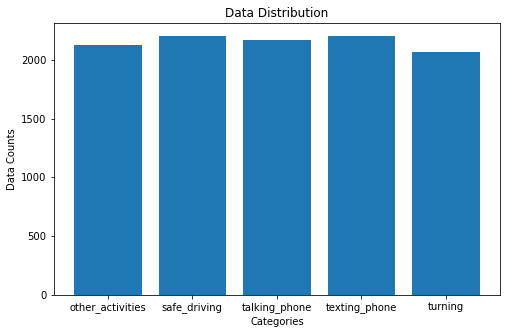

There're 10766 pictures in 5 categories in the dataset.

2128 pictures in other_activities category.
2203 pictures in safe_driving category.
2169 pictures in talking_phone category.
2203 pictures in texting_phone category.
2063 pictures in turning category.


In [138]:
plotDataDistribution(original_data_path)

Read information of images, if the image is readable, store its path and resolution in the data frame. 

If the image is not readable, store the file path in a list.

In [139]:
df_pic_info,error_file = readImgInfo(original_data_path)

Take a look at the readable file data set:

In [140]:
df_pic_info.sample(10)

,height,width,path
5908,480,640,data/talking_phone/img_40043.jpg
25,384,683,data/other_activities/2019-04-2416-47-34.png
5561,480,640,data/talking_phone/img_3352.jpg
7551,480,640,data/texting_phone/img_30711.jpg
435,480,640,data/other_activities/img_13918.jpg
7052,480,640,data/texting_phone/img_20643.jpg
8478,480,640,data/texting_phone/img_5680.jpg
886,480,640,data/other_activities/img_18974.jpg
1626,480,640,data/other_activities/img_4899.jpg
205,480,640,data/other_activities/img_11577.jpg


Show the files that could not be opened:

In [141]:
error_file

['data/other_activities/img_13318.jpg',
 'data/other_activities/img_13396.jpg',
 'data/other_activities/img_13541.jpg',
 'data/other_activities/img_13625.jpg',
 'data/other_activities/img_20398.jpg',
 'data/other_activities/img_22266.jpg',
 'data/other_activities/img_4664.jpg',
 'data/other_activities/img_79.jpg',
 'data/other_activities/img_7973.jpg',
 'data/turning/img_101434.jpg',
 'data/turning/img_62337.jpg',
 'data/turning/img_67523.jpg',
 'data/turning/img_70552.jpg',
 'data/turning/img_84605.jpg',
 'data/turning/img_8771.jpg']

Look at the resolution of the pictures:

In [142]:
unique_height = df_pic_info['height'].unique()
unique_width = df_pic_info['width'].unique()

print(f"There\'re {len(unique_height)} different height(s): {','.join([str(i) for i in unique_height])}")
print(f"There\'re {len(unique_width)} different width(s): {','.join([str(i) for i in unique_width])}")

There're 2 different height(s): 384,480
There're 2 different width(s): 683,640


Resize the images to a uniform resolution, stored the resized images in another folder, store the resized path to a text file:

In [145]:
resized_data_path = resizePic(df_pic_info['path'],"data_cleaned",640,384)


Picture Resize: 
Successed:	 10751 
Failed:	 0


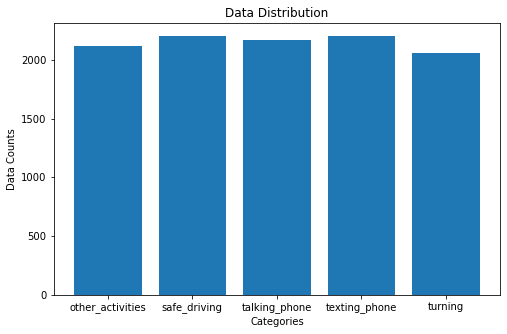

There're 10751 pictures in 5 categories in the dataset.

2119 pictures in other_activities category.
2203 pictures in safe_driving category.
2169 pictures in talking_phone category.
2203 pictures in texting_phone category.
2057 pictures in turning category.


In [146]:
plotDataDistribution(resized_data_path)

In [147]:
df_pic_info_resized ,error_file = readImgInfo(resized_data_path)

In [148]:
unique_height = df_pic_info_resized['height'].unique()
unique_width = df_pic_info_resized['width'].unique()

print(f"There\'re {len(unique_height)} different height(s): {','.join([str(i) for i in unique_height])}")
print(f"There\'re {len(unique_width)} different width(s): {','.join([str(i) for i in unique_width])}")

There're 1 different height(s): 384
There're 1 different width(s): 640


---

Read resized file path:

In [24]:
resized_data_path = readPathFromFile("data_cleaned")
resized_data_path

'data_cleaned'

Generate `Train` and `Test` data set from resized data set, store new sets in another path:

In [150]:
train_path, test_path = generate_Train_Test(resized_data_path,'data_organized',0.8)

Look at the data distribution in train set:

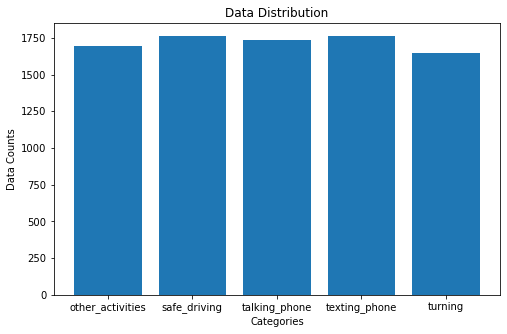

There're 8600 pictures in 5 categories in the dataset.

1695 pictures in other_activities category.
1762 pictures in safe_driving category.
1735 pictures in talking_phone category.
1762 pictures in texting_phone category.
1646 pictures in turning category.


In [151]:
plotDataDistribution(train_path)

We can see we have a balanced data across the categories.

Look at the data distribution in test set:

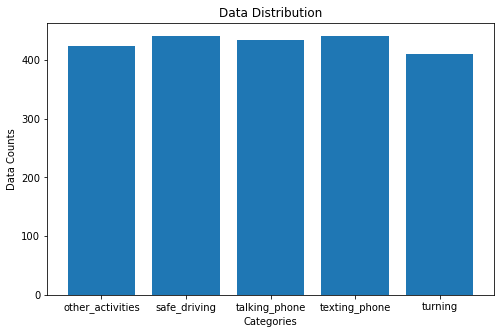

There're 2151 pictures in 5 categories in the dataset.

424 pictures in other_activities category.
441 pictures in safe_driving category.
434 pictures in talking_phone category.
441 pictures in texting_phone category.
411 pictures in turning category.


In [152]:
plotDataDistribution(test_path)

Read train & test data set path from text file:

In [22]:
train_path = readPathFromFile('train')
test_path = readPathFromFile('test')

In [23]:
train_path

'data_organized/train'

Set Model Parameters:

In [24]:
# The number of categories we have
categories = os.listdir(train_path)

# The number of classes we are trying to classify
classes = len(categories)

# We will re-size the images to 64 by 64 pixels to cut down on computation time 
#pixels = 64
pixels = 64

# They are colour images so they have 3 channels 
channels = 3

# We want to work with 12 images at a time (in each batch)
batch_size = 12

input_shape = (pixels,pixels,channels)

print(f'We have {classes} categories we are trying to classify.')

We have 5 categories we are trying to classify.


In [25]:
# Instantiating the train generator
train_datagen = ImageDataGenerator(rescale=1./255,validation_split = 0.3)

# Instantiating the test generator
test_datagen = ImageDataGenerator(rescale=1./255)

In [26]:
train_generator,validation_generator, test_generator = imgGeneator()

train_stepsize = train_generator.samples // train_generator.batch_size 
valid_stepsize = validation_generator.samples // validation_generator.batch_size 
test_stepsize = test_generator.samples // test_generator.batch_size 

print(f'\r\nTraining Sample Size:\t{train_generator.samples}\tBatch Size: {train_generator.batch_size}\tStep Size: {train_stepsize}\r\n')
print(f'Validation Sample Size:\t{validation_generator.samples}\tBatch Size: {validation_generator.batch_size}\tStep Size: {valid_stepsize}\r\n')
print(f'Test Sample Size:\t{test_generator.samples}\tBatch Size: {test_generator.batch_size}\tStep Size: {test_stepsize}\r\n')

Found 6023 images belonging to 5 classes.
Found 2577 images belonging to 5 classes.
Found 2151 images belonging to 5 classes.

Training Sample Size:	6023	Batch Size: 12	Step Size: 501

Validation Sample Size:	2577	Batch Size: 12	Step Size: 214

Test Sample Size:	2151	Batch Size: 12	Step Size: 179



Show how the pictures look in train and test folder:

**Train Set:**

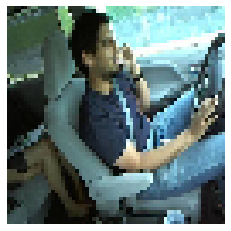

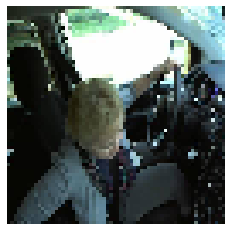

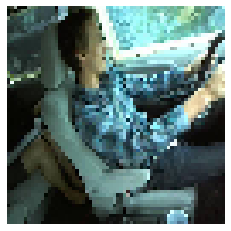

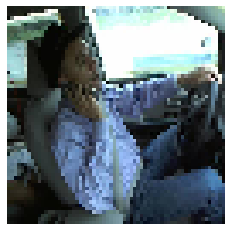

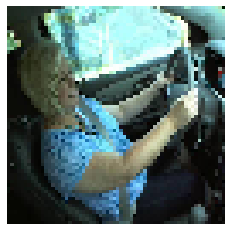

In [234]:
showGeneratorImage(train_generator,5)

**Test Set:**

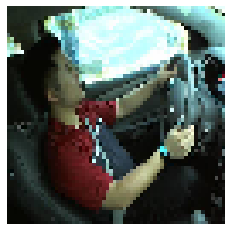

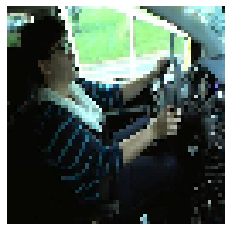

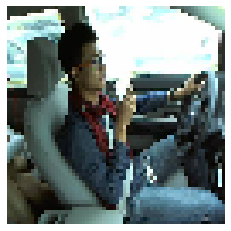

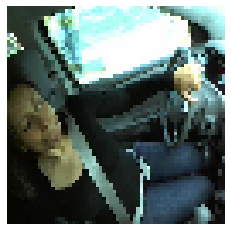

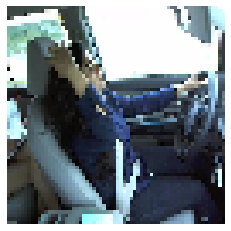

In [235]:
showGeneratorImage(test_generator,5)

Initialize Model:

---

**Transfer Learning From *MobileNet***

Using pre-trained MobileNet weights and one 5 neurons classifier output as the benchmark for the MobileNet transfer learning Model:

1. Initialize the model:

In [35]:
# Initialize pre-trained model
MobileNet_Benchmark = initPreTrained(input_shape,'mobilenet')

2. Compile the model:  

- default optimizer: Adam

- default learning rate: 0.0001

- loss function: categorical_crossentropy

- metrics: accuracy

In [36]:
# Compile the model
MobileNet_Benchmark = modelCompile(MobileNet_Benchmark)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 1024)              3228864   
_________________________________________________________________
dense (Dense)                (None, 5)                 5125      
Total params: 3,233,989
Trainable params: 5,125
Non-trainable params: 3,228,864
_________________________________________________________________
None


3. Train and evaluate the benchmark model:

Epoch 1/10
501/501 [==============================] - 47s 95ms/step - loss: 2.1284 - accuracy: 0.2510 - val_loss: 1.7544 - val_accuracy: 0.3201
Epoch 2/10
501/501 [==============================] - 47s 94ms/step - loss: 1.4720 - accuracy: 0.4051 - val_loss: 1.4315 - val_accuracy: 0.4428
Epoch 3/10
501/501 [==============================] - 48s 97ms/step - loss: 1.2066 - accuracy: 0.5142 - val_loss: 1.2565 - val_accuracy: 0.5167
Epoch 4/10
501/501 [==============================] - 47s 94ms/step - loss: 1.0406 - accuracy: 0.5886 - val_loss: 1.1343 - val_accuracy: 0.5783
Epoch 5/10
501/501 [==============================] - 47s 94ms/step - loss: 0.9215 - accuracy: 0.6460 - val_loss: 1.0505 - val_accuracy: 0.6059
Epoch 6/10
501/501 [==============================] - 47s 94ms/step - loss: 0.8299 - accuracy: 0.6936 - val_loss: 0.9859 - val_accuracy: 0.6460
Epoch 7/10
501/501 [==============================] - 47s 94ms/step - loss: 0.7577 - accuracy: 0.7255 - val_loss: 0.9367 - val_accuracy:

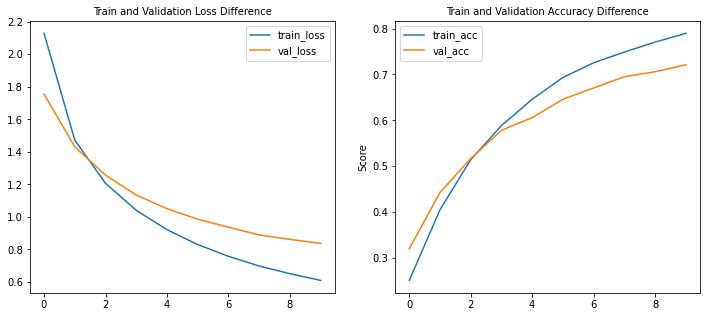

Classification Report
 
                   precision    recall  f1-score   support

other_activities       0.64      0.62      0.63       424
    safe_driving       0.77      0.80      0.79       441
   talking_phone       0.73      0.68      0.71       434
   texting_phone       0.68      0.75      0.71       441
         turning       0.92      0.90      0.91       411

        accuracy                           0.75      2151
       macro avg       0.75      0.75      0.75      2151
    weighted avg       0.75      0.75      0.75      2151



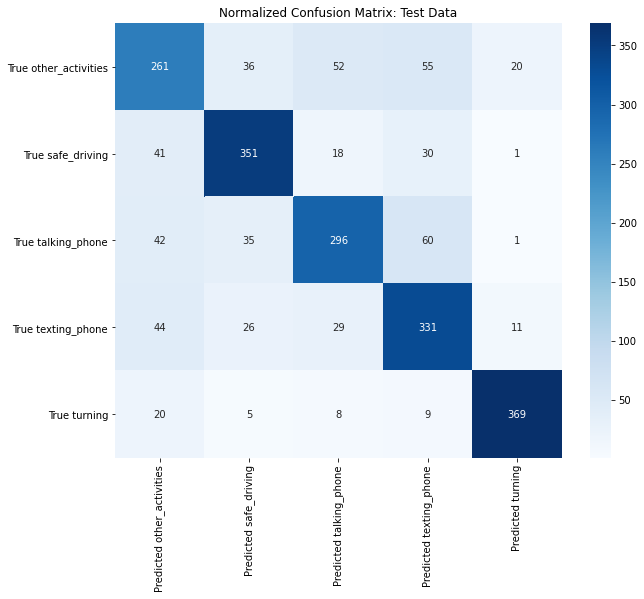

In [160]:
# returns (model, history,test_probas,test_predictions)
MobileNet_Benchmark =  model_Fit_Evaluate(MobileNet_Benchmark,10)

4. Save the benchmark model:

In [161]:
MobileNet_Benchmark[0].save('saved_model/MobileNet_Benchmark')

INFO:tensorflow:Assets written to: saved_model/MobileNet_Benchmark\assets


**Tweak MobileNet Benchmark Model:**

Add 3 hidden layers to the benchmark model, dropout is 0.15

1. Load the benchmark model:

In [162]:
# Read Becnmark model
MobileNet_Benchmark = tf.keras.models.load_model('saved_model/MobileNet_Benchmark')

2. Add layers and compile the model:

In [163]:
# Define layers, integer indicates neuron number, decimal indicates dropout rate
new_layers = [243, 0.15, 243, 0.15, 81]


MobileNet_3Layers = addLayers2Model_compile(MobileNet_Benchmark,new_layers)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 1024)              3228864   
_________________________________________________________________
dense_61 (Dense)             (None, 243)               249075    
_________________________________________________________________
dropout_32 (Dropout)         (None, 243)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 243)               59292     
_________________________________________________________________
dropout_33 (Dropout)         (None, 243)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 81)                19764     
_________________________________________________________________
dense_64 (Dense)             (None, 5)               

3. Train and evaluate the model:

Epoch 1/10
501/501 [==============================] - 48s 96ms/step - loss: 1.3626 - accuracy: 0.4473 - val_loss: 0.9880 - val_accuracy: 0.6382
Epoch 2/10
501/501 [==============================] - 49s 98ms/step - loss: 0.8426 - accuracy: 0.6741 - val_loss: 0.7459 - val_accuracy: 0.7422
Epoch 3/10
501/501 [==============================] - 45s 90ms/step - loss: 0.6022 - accuracy: 0.7804 - val_loss: 0.6198 - val_accuracy: 0.8061
Epoch 4/10
501/501 [==============================] - 45s 89ms/step - loss: 0.4417 - accuracy: 0.8423 - val_loss: 0.5577 - val_accuracy: 0.8322
Epoch 5/10
501/501 [==============================] - 46s 93ms/step - loss: 0.3388 - accuracy: 0.8816 - val_loss: 0.5260 - val_accuracy: 0.8477
Epoch 6/10
501/501 [==============================] - 45s 90ms/step - loss: 0.2539 - accuracy: 0.9138 - val_loss: 0.5258 - val_accuracy: 0.8590
Epoch 7/10
501/501 [==============================] - 44s 89ms/step - loss: 0.1962 - accuracy: 0.9358 - val_loss: 0.5030 - val_accuracy:

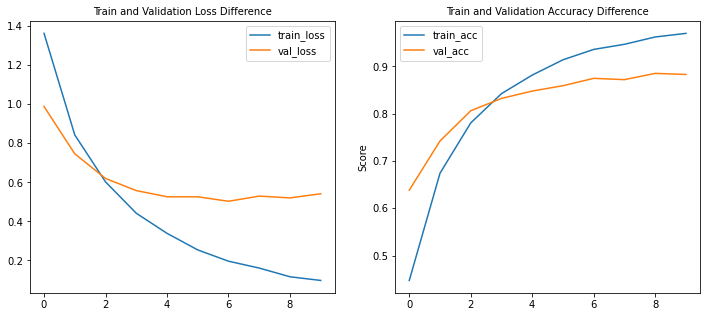

Classification Report
 
                   precision    recall  f1-score   support

other_activities       0.86      0.88      0.87       424
    safe_driving       0.88      0.95      0.92       441
   talking_phone       0.95      0.88      0.91       434
   texting_phone       0.92      0.89      0.90       441
         turning       0.96      0.96      0.96       411

        accuracy                           0.91      2151
       macro avg       0.91      0.91      0.91      2151
    weighted avg       0.91      0.91      0.91      2151



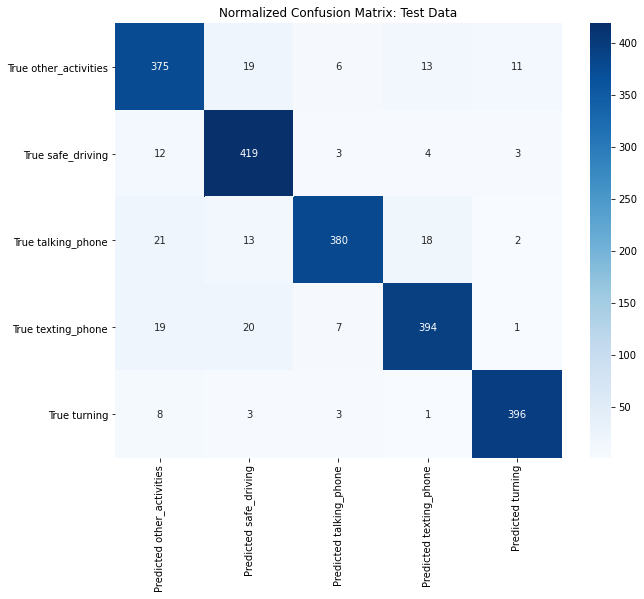

In [164]:
MobileNet_3Layers =  model_Fit_Evaluate(MobileNet_3Layers,10)

4. Save the model:

In [165]:
MobileNet_3Layers[0].save('saved_model/MobileNet_3Layers')

INFO:tensorflow:Assets written to: saved_model/MobileNet_3Layers\assets


**Tweak MobileNet Benchmark Model:**

Add 5 hidden layers to the benchmark model with different dropout.

1. Load the benchmark model:

In [166]:
MobileNet_Benchmark = tf.keras.models.load_model('saved_model/MobileNet_Benchmark')

2. Add layers and compile the Model:
- Add 5 hidden layers to the benchmark model with different dropout.

In [167]:
# Define layers, integer indicates neuron number, decimal indicates dropout rate
new_layers = [512,0.2, 371,0.1, 243, 0.15, 243, 0.15, 81]


MobileNet_5Layers = addLayers2Model_compile(MobileNet_Benchmark,new_layers)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 1024)              3228864   
_________________________________________________________________
dense_65 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_34 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 371)               190323    
_________________________________________________________________
dropout_35 (Dropout)         (None, 371)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 243)               90396     
_________________________________________________________________
dropout_36 (Dropout)         (None, 243)             

3. Train and evaluate the model:

Epoch 1/10
501/501 [==============================] - 46s 92ms/step - loss: 1.3715 - accuracy: 0.4084 - val_loss: 0.9860 - val_accuracy: 0.6425
Epoch 2/10
501/501 [==============================] - 45s 89ms/step - loss: 0.8380 - accuracy: 0.6708 - val_loss: 0.7211 - val_accuracy: 0.7636
Epoch 3/10
501/501 [==============================] - 44s 89ms/step - loss: 0.5401 - accuracy: 0.7969 - val_loss: 0.5683 - val_accuracy: 0.8322
Epoch 4/10
501/501 [==============================] - 44s 88ms/step - loss: 0.3797 - accuracy: 0.8676 - val_loss: 0.5488 - val_accuracy: 0.8528
Epoch 5/10
501/501 [==============================] - 44s 88ms/step - loss: 0.2485 - accuracy: 0.9143 - val_loss: 0.5408 - val_accuracy: 0.8746
Epoch 6/10
501/501 [==============================] - 44s 87ms/step - loss: 0.1855 - accuracy: 0.9341 - val_loss: 0.5042 - val_accuracy: 0.8758
Epoch 7/10
501/501 [==============================] - 45s 90ms/step - loss: 0.1310 - accuracy: 0.9547 - val_loss: 0.5178 - val_accuracy:

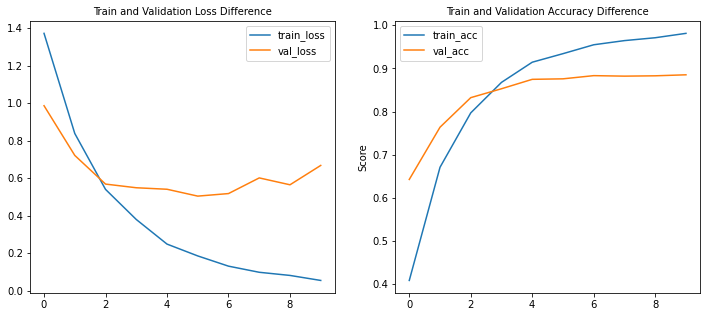

Classification Report
 
                   precision    recall  f1-score   support

other_activities       0.89      0.88      0.88       424
    safe_driving       0.97      0.88      0.92       441
   talking_phone       0.90      0.92      0.91       434
   texting_phone       0.88      0.94      0.91       441
         turning       0.94      0.97      0.95       411

        accuracy                           0.91      2151
       macro avg       0.92      0.91      0.91      2151
    weighted avg       0.92      0.91      0.91      2151



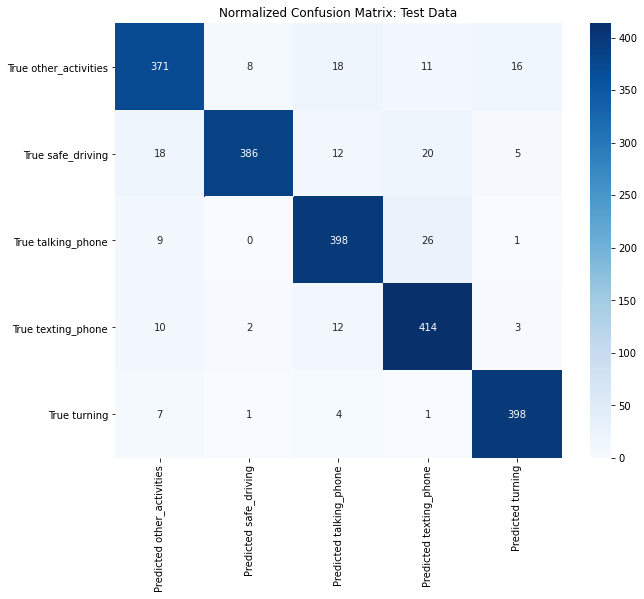

In [168]:
MobileNet_5Layers =  model_Fit_Evaluate(MobileNet_5Layers,10)

4. Save the model:

In [169]:
MobileNet_5Layers[0].save('saved_model/MobileNet_5Layers')

INFO:tensorflow:Assets written to: saved_model/MobileNet_5Layers\assets


---

**Transfer Learning From *MobileNetV2*** 

Using pre-trained MobileNetV2 weights and same parameters as MobileNet model to build a MobileNetV2 benchmark model:

1. Initialize the model:

In [170]:
# Initialize pre-trained model
MobileNetV2_Benchmark = initPreTrained(input_shape,'mobilenetv2')

2. Compile the model:

In [171]:
# Compile the model
MobileNetV2_Benchmark = modelCompile(MobileNetV2_Benchmark)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 1280)              2257984   
_________________________________________________________________
dense_71 (Dense)             (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________
None


3. Train and evaluate the benchmark model:

Epoch 1/10
501/501 [==============================] - 39s 77ms/step - loss: 1.6992 - accuracy: 0.2958 - val_loss: 1.5099 - val_accuracy: 0.3695
Epoch 2/10
501/501 [==============================] - 37s 75ms/step - loss: 1.3319 - accuracy: 0.4415 - val_loss: 1.3166 - val_accuracy: 0.4759
Epoch 3/10
501/501 [==============================] - 38s 76ms/step - loss: 1.1580 - accuracy: 0.5403 - val_loss: 1.2015 - val_accuracy: 0.5417
Epoch 4/10
501/501 [==============================] - 38s 76ms/step - loss: 1.0393 - accuracy: 0.6091 - val_loss: 1.1196 - val_accuracy: 0.5884
Epoch 5/10
501/501 [==============================] - 39s 77ms/step - loss: 0.9510 - accuracy: 0.6583 - val_loss: 1.0566 - val_accuracy: 0.6172
Epoch 6/10
501/501 [==============================] - 37s 75ms/step - loss: 0.8799 - accuracy: 0.6907 - val_loss: 1.0111 - val_accuracy: 0.6351
Epoch 7/10
501/501 [==============================] - 37s 74ms/step - loss: 0.8201 - accuracy: 0.7187 - val_loss: 0.9673 - val_accuracy:

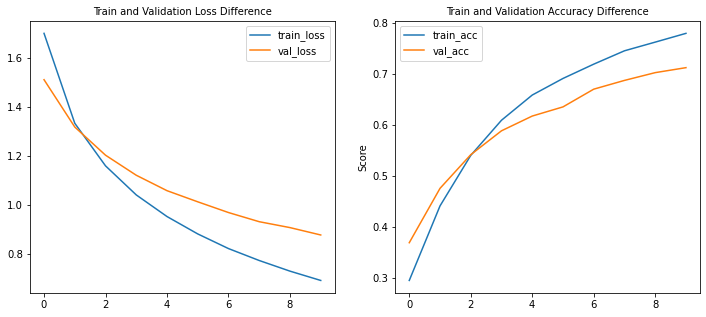

Classification Report
 
                   precision    recall  f1-score   support

other_activities       0.69      0.63      0.66       424
    safe_driving       0.79      0.81      0.80       441
   talking_phone       0.67      0.67      0.67       434
   texting_phone       0.71      0.72      0.71       441
         turning       0.87      0.90      0.89       411

        accuracy                           0.75      2151
       macro avg       0.75      0.75      0.75      2151
    weighted avg       0.74      0.75      0.75      2151



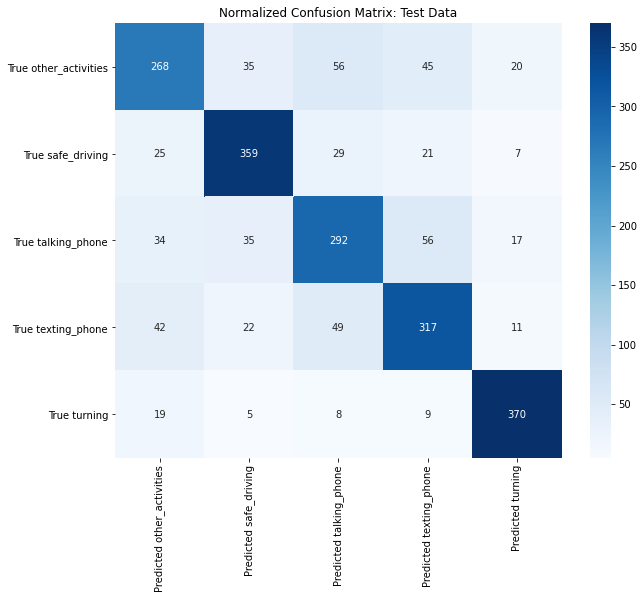

In [172]:
# returns (model, history,test_probas,test_predictions)
MobileNetV2_Benchmark =  model_Fit_Evaluate(MobileNetV2_Benchmark,10)

4. Save the model:

In [173]:
MobileNetV2_Benchmark[0].save('saved_model/MobileNetV2_Benchmark')

INFO:tensorflow:Assets written to: saved_model/MobileNetV2_Benchmark\assets


**Tweak MobileNetV2 Benchmark Model**

1. Load the benchmark model:

In [174]:
# Read Becnmark model
MobileNetV2_Benchmark = tf.keras.models.load_model('saved_model/MobileNetV2_Benchmark')

2. Add the same 3 hidden layers and compile the model:

In [175]:
# Define layers, integer indicates neuron number, decimal indicates dropout rate
new_layers = [243, 0.15, 243, 0.15, 81]


MobileNetV2_3Layers = addLayers2Model_compile(MobileNetV2_Benchmark,new_layers)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 1280)              2257984   
_________________________________________________________________
dense_72 (Dense)             (None, 243)               311283    
_________________________________________________________________
dropout_38 (Dropout)         (None, 243)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 243)               59292     
_________________________________________________________________
dropout_39 (Dropout)         (None, 243)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 81)                19764     
_________________________________________________________________
dense_75 (Dense)             (None, 5)               

3. Train and evaluate the model:

Epoch 1/10
501/501 [==============================] - 47s 94ms/step - loss: 1.3719 - accuracy: 0.4157 - val_loss: 1.0884 - val_accuracy: 0.5946
Epoch 2/10
501/501 [==============================] - 45s 91ms/step - loss: 0.9130 - accuracy: 0.6553 - val_loss: 0.8105 - val_accuracy: 0.7259
Epoch 3/10
501/501 [==============================] - 45s 90ms/step - loss: 0.6490 - accuracy: 0.7716 - val_loss: 0.7210 - val_accuracy: 0.7667
Epoch 4/10
501/501 [==============================] - 45s 89ms/step - loss: 0.4633 - accuracy: 0.8421 - val_loss: 0.6496 - val_accuracy: 0.8057
Epoch 5/10
501/501 [==============================] - 45s 91ms/step - loss: 0.3553 - accuracy: 0.8804 - val_loss: 0.5951 - val_accuracy: 0.8174
Epoch 6/10
501/501 [==============================] - 44s 88ms/step - loss: 0.2706 - accuracy: 0.9097 - val_loss: 0.5882 - val_accuracy: 0.8419
Epoch 7/10
501/501 [==============================] - 46s 93ms/step - loss: 0.2041 - accuracy: 0.9364 - val_loss: 0.5837 - val_accuracy:

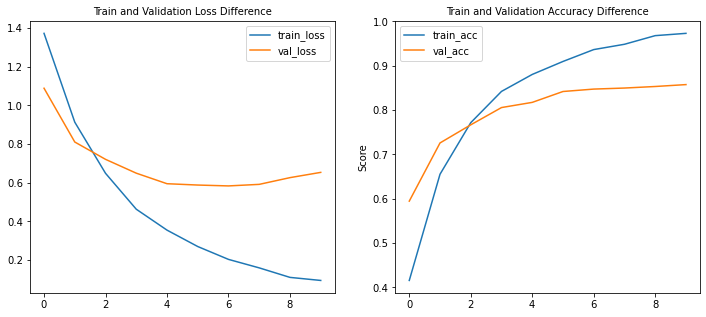

Classification Report
 
                   precision    recall  f1-score   support

other_activities       0.87      0.82      0.84       424
    safe_driving       0.95      0.88      0.92       441
   talking_phone       0.83      0.88      0.85       434
   texting_phone       0.89      0.91      0.90       441
         turning       0.91      0.96      0.93       411

        accuracy                           0.89      2151
       macro avg       0.89      0.89      0.89      2151
    weighted avg       0.89      0.89      0.89      2151



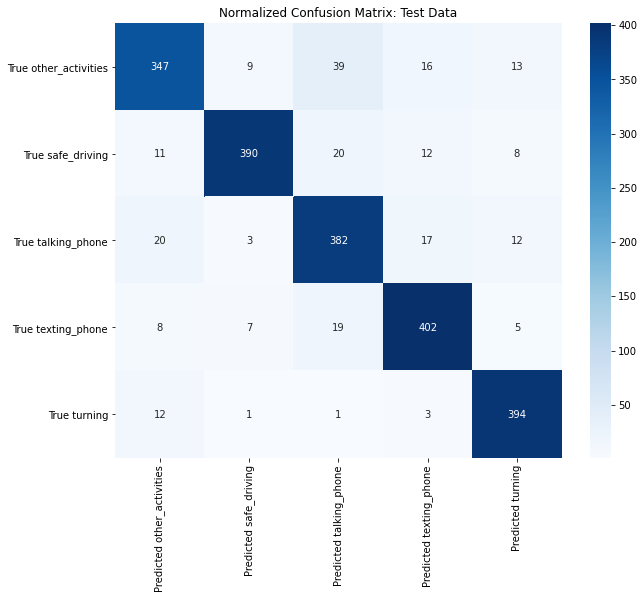

In [176]:
MobileNetV2_3Layers =  model_Fit_Evaluate(MobileNetV2_3Layers,10)

4. Save the model:

In [177]:
MobileNetV2_3Layers[0].save('saved_model/MobileNetV2_3Layers')

INFO:tensorflow:Assets written to: saved_model/MobileNetV2_3Layers\assets


**Tweak MobileNetV2 Benchmark Model:**

- Add the same 5 hidden layers.

1. Load the benchmark model:

In [178]:
MobileNetV2_Benchmark = tf.keras.models.load_model('saved_model/MobileNetV2_Benchmark')

2. Add the same 5 layers and compile the model

In [179]:
# Define layers, integer indicates neuron number, decimal indicates dropout rate
new_layers = [512,0.2,371,0.1,243, 0.15, 243, 0.15, 81]


MobileNetV2_5Layers = addLayers2Model_compile(MobileNetV2_Benchmark,new_layers)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 1280)              2257984   
_________________________________________________________________
dense_76 (Dense)             (None, 512)               655872    
_________________________________________________________________
dropout_40 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 371)               190323    
_________________________________________________________________
dropout_41 (Dropout)         (None, 371)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 243)               90396     
_________________________________________________________________
dropout_42 (Dropout)         (None, 243)             

3. Train and evaluate the model:

Epoch 1/10
501/501 [==============================] - 61s 121ms/step - loss: 1.4154 - accuracy: 0.3835 - val_loss: 1.0720 - val_accuracy: 0.5985
Epoch 2/10
501/501 [==============================] - 60s 120ms/step - loss: 0.9216 - accuracy: 0.6390 - val_loss: 0.8359 - val_accuracy: 0.7060
Epoch 3/10
501/501 [==============================] - 60s 119ms/step - loss: 0.5797 - accuracy: 0.7881 - val_loss: 0.6411 - val_accuracy: 0.7971
Epoch 4/10
501/501 [==============================] - 59s 119ms/step - loss: 0.3963 - accuracy: 0.8574 - val_loss: 0.6554 - val_accuracy: 0.8174
Epoch 5/10
501/501 [==============================] - 59s 118ms/step - loss: 0.2816 - accuracy: 0.9033 - val_loss: 0.6043 - val_accuracy: 0.8400
Epoch 6/10
501/501 [==============================] - 58s 116ms/step - loss: 0.1983 - accuracy: 0.9295 - val_loss: 0.6257 - val_accuracy: 0.8458
Epoch 7/10
501/501 [==============================] - 60s 119ms/step - loss: 0.1446 - accuracy: 0.9483 - val_loss: 0.6665 - val_ac

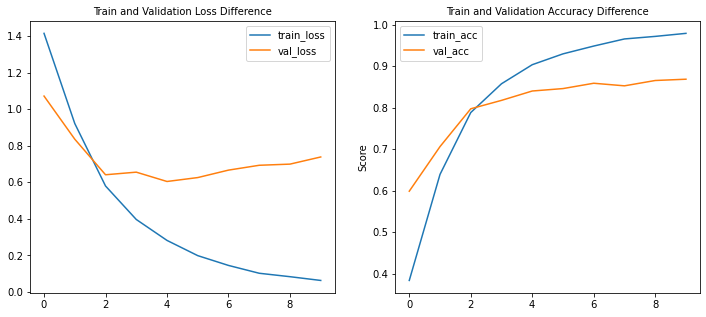

Classification Report
 
                   precision    recall  f1-score   support

other_activities       0.92      0.82      0.86       424
    safe_driving       0.93      0.94      0.93       441
   talking_phone       0.90      0.90      0.90       434
   texting_phone       0.87      0.94      0.90       441
         turning       0.94      0.95      0.94       411

        accuracy                           0.91      2151
       macro avg       0.91      0.91      0.91      2151
    weighted avg       0.91      0.91      0.91      2151



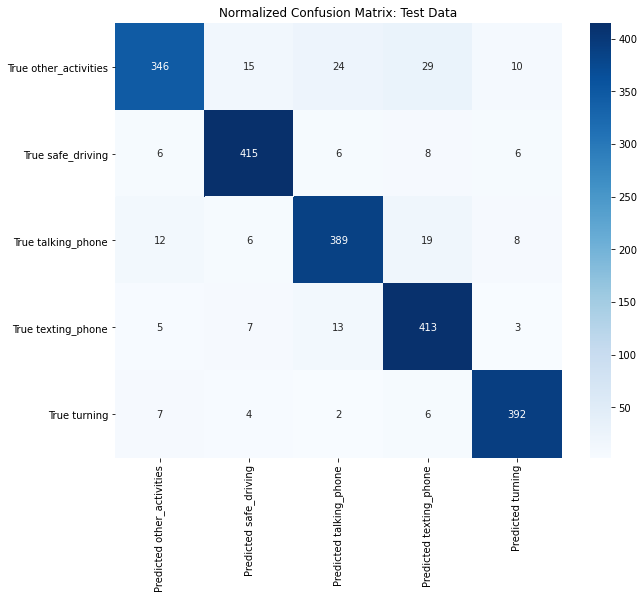

In [180]:
MobileNetV2_5Layers =  model_Fit_Evaluate(MobileNetV2_5Layers,10)

4. Save the model:

In [181]:
MobileNetV2_5Layers[0].save('saved_model/MobileNetV2_5Layers')

INFO:tensorflow:Assets written to: saved_model/MobileNetV2_5Layers\assets


---

**Transfer Learning From *VGG16*** 

Using pre-trained VGG16 weights and one 5 neurons classifier output as the benchmark for the VGG16 transfer learning model:

1. Initialize the model:

In [272]:
VGG16_Benchmark = initPreTrained(input_shape,'Vgg16')

2. Compile the model:

In [273]:
VGG16_Benchmark = modelCompile(VGG16_Benchmark)

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_99 (Dense)             (None, 5)                 2565      
Total params: 14,717,253
Trainable params: 2,565
Non-trainable params: 14,714,688
_________________________________________________________________
None


3. Train and evaluate the model:

Epoch 1/10
501/501 [==============================] - 759s 2s/step - loss: 1.6308 - accuracy: 0.2304 - val_loss: 1.5755 - val_accuracy: 0.2847
Epoch 2/10
501/501 [==============================] - 762s 2s/step - loss: 1.5057 - accuracy: 0.3434 - val_loss: 1.4918 - val_accuracy: 0.3544
Epoch 3/10
501/501 [==============================] - 766s 2s/step - loss: 1.4226 - accuracy: 0.4249 - val_loss: 1.4318 - val_accuracy: 0.4023
Epoch 4/10
501/501 [==============================] - 762s 2s/step - loss: 1.3563 - accuracy: 0.4756 - val_loss: 1.3780 - val_accuracy: 0.4537
Epoch 5/10
501/501 [==============================] - 749s 1s/step - loss: 1.3031 - accuracy: 0.5151 - val_loss: 1.3350 - val_accuracy: 0.4786
Epoch 6/10
501/501 [==============================] - 746s 1s/step - loss: 1.2559 - accuracy: 0.5513 - val_loss: 1.2979 - val_accuracy: 0.5105
Epoch 7/10
501/501 [==============================] - 745s 1s/step - loss: 1.2154 - accuracy: 0.5758 - val_loss: 1.2645 - val_accuracy: 0.5308

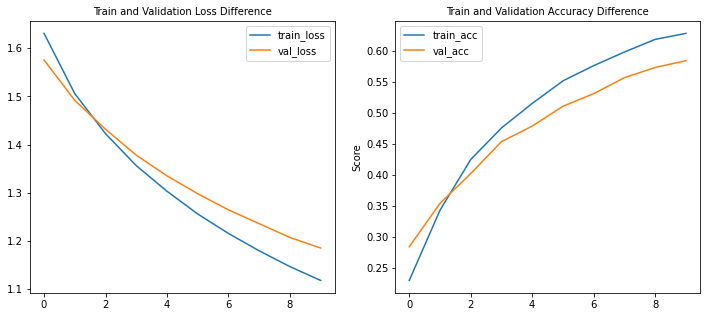

Classification Report
 
                   precision    recall  f1-score   support

other_activities       0.65      0.45      0.53       424
    safe_driving       0.66      0.72      0.69       441
   talking_phone       0.54      0.40      0.46       434
   texting_phone       0.51      0.68      0.58       441
         turning       0.76      0.88      0.82       411

        accuracy                           0.62      2151
       macro avg       0.62      0.62      0.62      2151
    weighted avg       0.62      0.62      0.61      2151



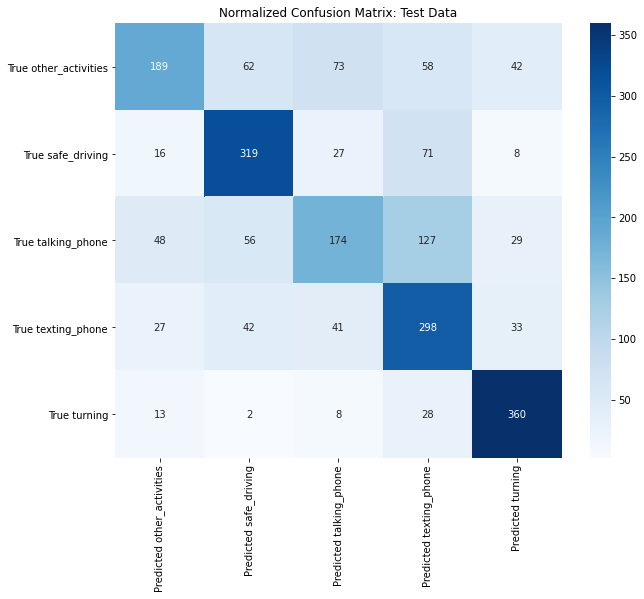

In [274]:
VGG16_Benchmark =  model_Fit_Evaluate(VGG16_Benchmark,10)

4. Same the VGG16 benchmark model:

In [275]:
VGG16_Benchmark[0].save('saved_model/VGG16_Benchmark')

INFO:tensorflow:Assets written to: saved_model/VGG16_Benchmark\assets


**Tweak VGG16 Benchmark Model:**

- Add the same 3 hidden layers.

1. Load the benchmark model:

In [276]:
VGG16_Benchmark = tf.keras.models.load_model('saved_model/VGG16_Benchmark')

2. Add the same 3 layers and compile the model:

In [277]:
new_layers = [243, 0.15, 243, 0.15, 81]
VGG16_3Layers = addLayers2Model_compile(VGG16_Benchmark,new_layers)

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_100 (Dense)            (None, 243)               124659    
_________________________________________________________________
dropout_56 (Dropout)         (None, 243)               0         
_________________________________________________________________
dense_101 (Dense)            (None, 243)               59292     
_________________________________________________________________
dropout_57 (Dropout)         (None, 243)               0         
_________________________________________________________________
dense_102 (Dense)            (None, 81)                19764     
_________________________________________________________________
dense_103 (Dense)            (None, 5)               

3. Train and evaluate the model:

Epoch 1/10
501/501 [==============================] - 751s 1s/step - loss: 1.4494 - accuracy: 0.3665 - val_loss: 1.2675 - val_accuracy: 0.4498
Epoch 2/10
501/501 [==============================] - 747s 1s/step - loss: 1.1162 - accuracy: 0.5482 - val_loss: 0.9909 - val_accuracy: 0.6488
Epoch 3/10
501/501 [==============================] - 748s 1s/step - loss: 0.9010 - accuracy: 0.6546 - val_loss: 0.8442 - val_accuracy: 0.7005
Epoch 4/10
501/501 [==============================] - 749s 1s/step - loss: 0.7411 - accuracy: 0.7250 - val_loss: 0.7748 - val_accuracy: 0.7294
Epoch 5/10
501/501 [==============================] - 751s 1s/step - loss: 0.6320 - accuracy: 0.7699 - val_loss: 0.6560 - val_accuracy: 0.7827
Epoch 6/10
501/501 [==============================] - 751s 1s/step - loss: 0.5464 - accuracy: 0.8092 - val_loss: 0.6237 - val_accuracy: 0.7940
Epoch 7/10
501/501 [==============================] - 751s 1s/step - loss: 0.4676 - accuracy: 0.8351 - val_loss: 0.6057 - val_accuracy: 0.8010

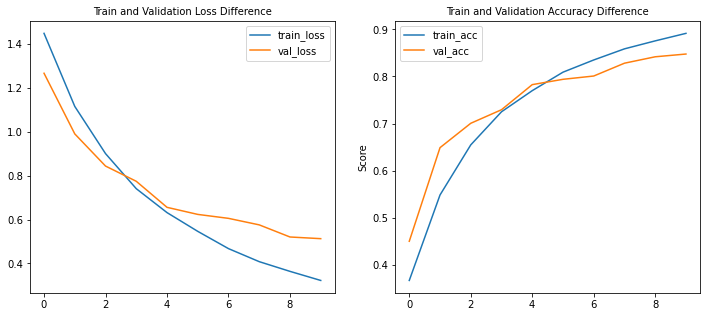

Classification Report
 
                   precision    recall  f1-score   support

other_activities       0.82      0.86      0.84       424
    safe_driving       0.92      0.91      0.92       441
   talking_phone       0.85      0.88      0.86       434
   texting_phone       0.90      0.85      0.87       441
         turning       0.97      0.94      0.95       411

        accuracy                           0.89      2151
       macro avg       0.89      0.89      0.89      2151
    weighted avg       0.89      0.89      0.89      2151



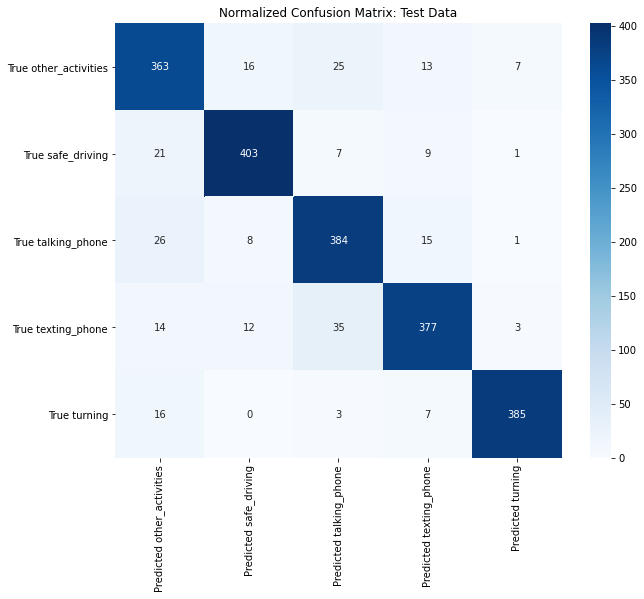

In [278]:
VGG16_3Layers =  model_Fit_Evaluate(VGG16_3Layers,10)

4. Same the model:

In [279]:
VGG16_3Layers[0].save('saved_model/VGG16_3Layers')

INFO:tensorflow:Assets written to: saved_model/VGG16_3Layers\assets


---

**Transfer Learning From *VGG19*** 

Using pre-trained VGG19 weights and one 5 neurons classifier output as the benchmark for the VGG19 transfer learning model:

1. Initialize the model:

In [280]:
VGG19_Benchmark = initPreTrained(input_shape,'Vgg19')

2. Compile the model:

In [281]:
VGG19_Benchmark = modelCompile(VGG19_Benchmark)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 512)               20024384  
_________________________________________________________________
dense_104 (Dense)            (None, 5)                 2565      
Total params: 20,026,949
Trainable params: 2,565
Non-trainable params: 20,024,384
_________________________________________________________________
None


3. Train and evaluate the model:

Epoch 1/10
501/501 [==============================] - 904s 2s/step - loss: 1.5620 - accuracy: 0.3013 - val_loss: 1.5370 - val_accuracy: 0.3170
Epoch 2/10
501/501 [==============================] - 904s 2s/step - loss: 1.4679 - accuracy: 0.3810 - val_loss: 1.4659 - val_accuracy: 0.3707
Epoch 3/10
501/501 [==============================] - 902s 2s/step - loss: 1.3965 - accuracy: 0.4339 - val_loss: 1.4105 - val_accuracy: 0.4182
Epoch 4/10
501/501 [==============================] - 900s 2s/step - loss: 1.3398 - accuracy: 0.4765 - val_loss: 1.3647 - val_accuracy: 0.4505
Epoch 5/10
501/501 [==============================] - 902s 2s/step - loss: 1.2919 - accuracy: 0.5096 - val_loss: 1.3256 - val_accuracy: 0.4712
Epoch 6/10
501/501 [==============================] - 903s 2s/step - loss: 1.2509 - accuracy: 0.5330 - val_loss: 1.2918 - val_accuracy: 0.5012
Epoch 7/10
501/501 [==============================] - 901s 2s/step - loss: 1.2135 - accuracy: 0.5585 - val_loss: 1.2614 - val_accuracy: 0.5222

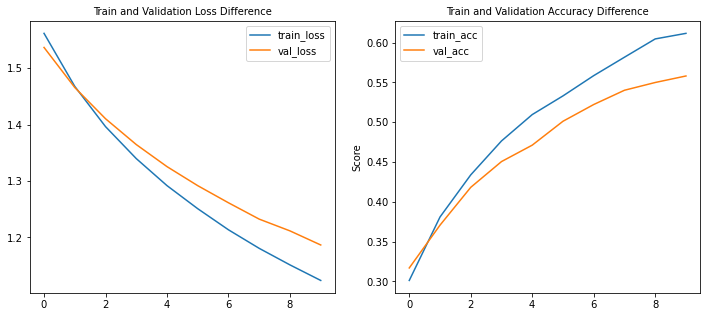

Classification Report
 
                   precision    recall  f1-score   support

other_activities       0.54      0.49      0.51       424
    safe_driving       0.60      0.69      0.64       441
   talking_phone       0.52      0.40      0.45       434
   texting_phone       0.50      0.58      0.54       441
         turning       0.81      0.83      0.82       411

        accuracy                           0.60      2151
       macro avg       0.60      0.60      0.59      2151
    weighted avg       0.59      0.60      0.59      2151



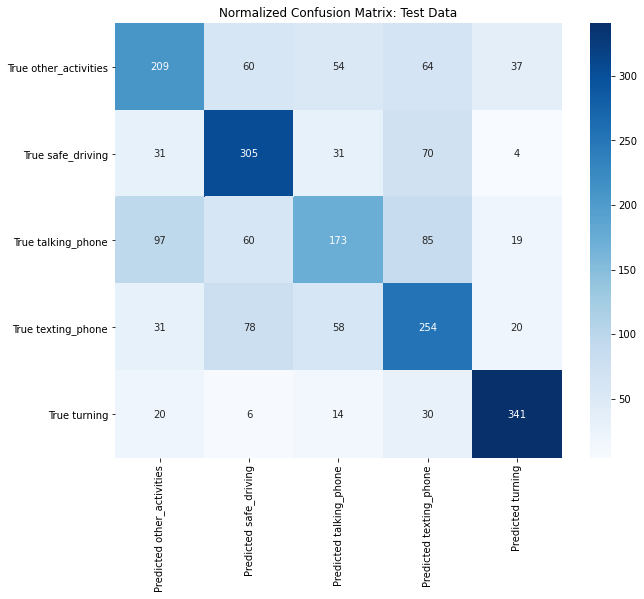

In [282]:
VGG19_Benchmark =  model_Fit_Evaluate(VGG19_Benchmark,10)

4. Same the VGG19 benchmark model:

In [283]:
VGG19_Benchmark[0].save('saved_model/VGG19_Benchmark')

INFO:tensorflow:Assets written to: saved_model/VGG19_Benchmark\assets


**Tweak VGG19 Benchmark Model:**

- Add the same 3 hidden layers.

1. Load the benchmark model:

In [284]:
VGG19_Benchmark = tf.keras.models.load_model('saved_model/VGG19_Benchmark')

2. Add the same layers and compile the model:

In [285]:
new_layers = [243, 0.15, 243, 0.15, 81]
VGG19_3Layers = addLayers2Model_compile(VGG19_Benchmark,new_layers)

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 512)               20024384  
_________________________________________________________________
dense_105 (Dense)            (None, 243)               124659    
_________________________________________________________________
dropout_58 (Dropout)         (None, 243)               0         
_________________________________________________________________
dense_106 (Dense)            (None, 243)               59292     
_________________________________________________________________
dropout_59 (Dropout)         (None, 243)               0         
_________________________________________________________________
dense_107 (Dense)            (None, 81)                19764     
_________________________________________________________________
dense_108 (Dense)            (None, 5)               

3. Train and Evaluate the model:

Epoch 1/10
501/501 [==============================] - 891s 2s/step - loss: 1.4841 - accuracy: 0.3547 - val_loss: 1.2814 - val_accuracy: 0.5062
Epoch 2/10
501/501 [==============================] - 892s 2s/step - loss: 1.1391 - accuracy: 0.5483 - val_loss: 1.0363 - val_accuracy: 0.6195
Epoch 3/10
501/501 [==============================] - 893s 2s/step - loss: 0.9264 - accuracy: 0.6432 - val_loss: 0.9169 - val_accuracy: 0.6690
Epoch 4/10
501/501 [==============================] - 892s 2s/step - loss: 0.7901 - accuracy: 0.6982 - val_loss: 0.8084 - val_accuracy: 0.7107
Epoch 5/10
501/501 [==============================] - 891s 2s/step - loss: 0.6731 - accuracy: 0.7476 - val_loss: 0.7148 - val_accuracy: 0.7597
Epoch 6/10
501/501 [==============================] - 890s 2s/step - loss: 0.5867 - accuracy: 0.7881 - val_loss: 0.7101 - val_accuracy: 0.7675
Epoch 7/10
501/501 [==============================] - 888s 2s/step - loss: 0.5120 - accuracy: 0.8227 - val_loss: 0.6548 - val_accuracy: 0.7979

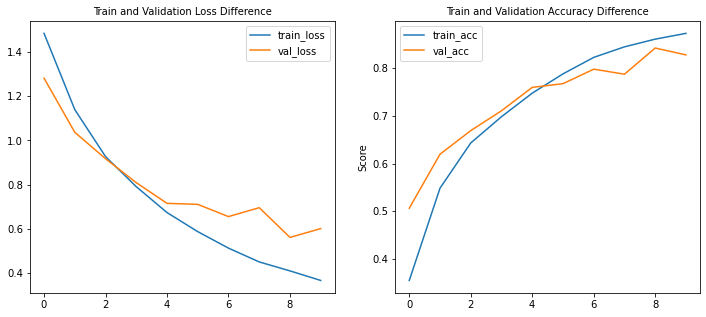

Classification Report
 
                   precision    recall  f1-score   support

other_activities       0.90      0.71      0.80       424
    safe_driving       0.94      0.81      0.87       441
   talking_phone       0.80      0.86      0.83       434
   texting_phone       0.76      0.95      0.84       441
         turning       0.93      0.96      0.94       411

        accuracy                           0.86      2151
       macro avg       0.87      0.86      0.86      2151
    weighted avg       0.87      0.86      0.86      2151



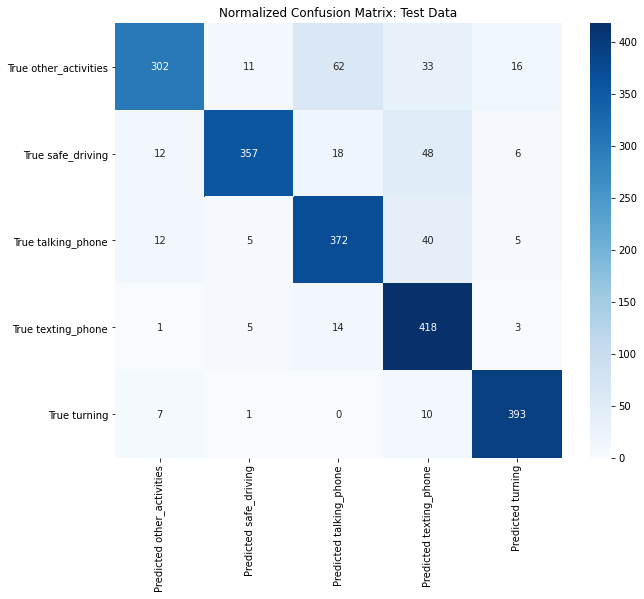

In [286]:
VGG19_3Layers =  model_Fit_Evaluate(VGG19_3Layers,10)

4. Same the model:

In [287]:
VGG19_3Layers[0].save('saved_model/VGG19_3Layers')

INFO:tensorflow:Assets written to: saved_model/VGG19_3Layers\assets


---

**Model Comparison:**

Load models:

In [20]:
# MobileNet
MobileNet_Benchmark = tf.keras.models.load_model('saved_model/MobileNet_Benchmark')
MobileNet_3Layers = tf.keras.models.load_model('saved_model/MobileNet_3Layers')
MobileNet_5Layers = tf.keras.models.load_model('saved_model/MobileNet_5Layers')

# MobileNetV2
MobileNetV2_Benchmark = tf.keras.models.load_model('saved_model/MobileNetV2_Benchmark')
MobileNetV2_3Layers = tf.keras.models.load_model('saved_model/MobileNetV2_3Layers')
MobileNetV2_5Layers = tf.keras.models.load_model('saved_model/MobileNetV2_5Layers')

# VGG16
VGG16_Benchmark = tf.keras.models.load_model('saved_model/VGG16_Benchmark')
VGG16_3Layers = tf.keras.models.load_model('saved_model/VGG16_3Layers')

# VGG19
VGG19_Benchmark = tf.keras.models.load_model('saved_model/VGG19_Benchmark')
VGG19_3Layers = tf.keras.models.load_model('saved_model/VGG19_3Layers')

First, we compare all the benchmark models:

**MobileNet Benchmark:**

In [186]:
printClassificationReport(MobileNet_Benchmark)

Prediction Time: 15 seconds.

Classification Report
 
                   precision    recall  f1-score   support

other_activities       0.64      0.62      0.63       424
    safe_driving       0.77      0.80      0.79       441
   talking_phone       0.73      0.68      0.71       434
   texting_phone       0.68      0.75      0.71       441
         turning       0.92      0.90      0.91       411

        accuracy                           0.75      2151
       macro avg       0.75      0.75      0.75      2151
    weighted avg       0.75      0.75      0.75      2151



Accuracy:

In [31]:
MobileNet_Benchmark.evaluate_generator(
    test_generator, steps=test_stepsize, callbacks=None, max_queue_size=10, workers=1,
    use_multiprocessing=False, verbose=1
)

179/179 [==============================] - 8s 45ms/step - loss: 0.7126 - accuracy: 0.7472


[0.7126121520996094, 0.7472066879272461]

**MobileNetV2 Benchmark:**

In [187]:
printClassificationReport(MobileNetV2_Benchmark)

Prediction Time: 14 seconds.

Classification Report
 
                   precision    recall  f1-score   support

other_activities       0.69      0.63      0.66       424
    safe_driving       0.79      0.81      0.80       441
   talking_phone       0.67      0.67      0.67       434
   texting_phone       0.71      0.72      0.71       441
         turning       0.87      0.90      0.89       411

        accuracy                           0.75      2151
       macro avg       0.75      0.75      0.75      2151
    weighted avg       0.74      0.75      0.75      2151



Accuracy:

In [32]:
MobileNetV2_Benchmark.evaluate_generator(
    test_generator, steps=test_stepsize, callbacks=None, max_queue_size=10, workers=1,
    use_multiprocessing=False, verbose=1
)

179/179 [==============================] - 8s 44ms/step - loss: 0.7787 - accuracy: 0.7463


[0.778653085231781, 0.7462756037712097]

**VGG16 Benchmark:**

In [290]:
printClassificationReport(VGG16_Benchmark)

Prediction Time: 204 seconds.

Classification Report
 
                   precision    recall  f1-score   support

other_activities       0.65      0.45      0.53       424
    safe_driving       0.66      0.72      0.69       441
   talking_phone       0.54      0.40      0.46       434
   texting_phone       0.51      0.68      0.58       441
         turning       0.76      0.88      0.82       411

        accuracy                           0.62      2151
       macro avg       0.62      0.62      0.62      2151
    weighted avg       0.62      0.62      0.61      2151



Accuracy:

In [33]:
VGG16_Benchmark.evaluate_generator(
    test_generator, steps=test_stepsize, callbacks=None, max_queue_size=10, workers=1,
    use_multiprocessing=False, verbose=1
)

179/179 [==============================] - 23s 127ms/step - loss: 1.1316 - accuracy: 0.6224


[1.1315937042236328, 0.6224395036697388]

**VGG19 Benchmark:**

In [291]:
printClassificationReport(VGG19_Benchmark)

Prediction Time: 255 seconds.

Classification Report
 
                   precision    recall  f1-score   support

other_activities       0.54      0.49      0.51       424
    safe_driving       0.60      0.69      0.64       441
   talking_phone       0.52      0.40      0.45       434
   texting_phone       0.50      0.58      0.54       441
         turning       0.81      0.83      0.82       411

        accuracy                           0.60      2151
       macro avg       0.60      0.60      0.59      2151
    weighted avg       0.59      0.60      0.59      2151



Accuracy:

In [34]:
VGG19_Benchmark.evaluate_generator(
    test_generator, steps=test_stepsize, callbacks=None, max_queue_size=10, workers=1,
    use_multiprocessing=False, verbose=1
)

179/179 [==============================] - 29s 160ms/step - loss: 1.1396 - accuracy: 0.5954


[1.1395845413208008, 0.5954376459121704]

As we can see from above classification report and accuracy, both `VGG16_Benchmark` & `VGG19_Benchmark` have the lowest perfomance, they  took much longer time to make the prediction by given the same size of data points. If our model is going to be use in an embedded system, we need a model which will not consume too much time on reaction.

Let's take a look at the model performance after added 3 more hidden layers.

**MobileNet with 3 more hidden layers**

In [190]:
printClassificationReport(MobileNet_3Layers)

Prediction Time: 15 seconds.

Classification Report
 
                   precision    recall  f1-score   support

other_activities       0.86      0.88      0.87       424
    safe_driving       0.88      0.95      0.92       441
   talking_phone       0.95      0.88      0.91       434
   texting_phone       0.92      0.89      0.90       441
         turning       0.96      0.96      0.96       411

        accuracy                           0.91      2151
       macro avg       0.91      0.91      0.91      2151
    weighted avg       0.91      0.91      0.91      2151



Accuracy:

In [35]:
MobileNet_3Layers.evaluate_generator(
    test_generator, steps=test_stepsize, callbacks=None, max_queue_size=10, workers=1,
    use_multiprocessing=False, verbose=1
)

179/179 [==============================] - 8s 45ms/step - loss: 0.3504 - accuracy: 0.9129


[0.35044077038764954, 0.9129422903060913]

**MobileNetV2 with 3 more hidden layers**

In [191]:
printClassificationReport(MobileNetV2_3Layers)

Prediction Time: 14 seconds.

Classification Report
 
                   precision    recall  f1-score   support

other_activities       0.87      0.82      0.84       424
    safe_driving       0.95      0.88      0.92       441
   talking_phone       0.83      0.88      0.85       434
   texting_phone       0.89      0.91      0.90       441
         turning       0.91      0.96      0.93       411

        accuracy                           0.89      2151
       macro avg       0.89      0.89      0.89      2151
    weighted avg       0.89      0.89      0.89      2151



Accuracy:

In [36]:
MobileNetV2_3Layers.evaluate_generator(
    test_generator, steps=test_stepsize, callbacks=None, max_queue_size=10, workers=1,
    use_multiprocessing=False, verbose=1
)

179/179 [==============================] - 8s 44ms/step - loss: 0.4195 - accuracy: 0.8906


[0.4195045530796051, 0.8905959129333496]

**VGG16 with 3 more hidden layers**

In [192]:
printClassificationReport(VGG16_3Layers)

Prediction Time: 175 seconds.

Classification Report
 
                   precision    recall  f1-score   support

other_activities       0.87      0.89      0.88       424
    safe_driving       0.91      0.95      0.93       441
   talking_phone       0.93      0.88      0.91       434
   texting_phone       0.92      0.90      0.91       441
         turning       0.96      0.97      0.97       411

        accuracy                           0.92      2151
       macro avg       0.92      0.92      0.92      2151
    weighted avg       0.92      0.92      0.92      2151



Accuracy:

In [37]:
VGG16_3Layers.evaluate_generator(
    test_generator, steps=test_stepsize, callbacks=None, max_queue_size=10, workers=1,
    use_multiprocessing=False, verbose=1
)

179/179 [==============================] - 24s 132ms/step - loss: 0.3689 - accuracy: 0.8887


[0.3688746690750122, 0.8887336850166321]

**VGG19 with 3 more hidden layers**

In [194]:
printClassificationReport(VGG19_3Layers)

Prediction Time: 214 seconds.

Classification Report
 
                   precision    recall  f1-score   support

other_activities       0.92      0.81      0.86       424
    safe_driving       0.92      0.93      0.93       441
   talking_phone       0.87      0.91      0.89       434
   texting_phone       0.86      0.90      0.88       441
         turning       0.95      0.96      0.96       411

        accuracy                           0.90      2151
       macro avg       0.90      0.90      0.90      2151
    weighted avg       0.90      0.90      0.90      2151



Accuracy:

In [38]:
VGG19_3Layers.evaluate_generator(
    test_generator, steps=test_stepsize, callbacks=None, max_queue_size=10, workers=1,
    use_multiprocessing=False, verbose=1
)

179/179 [==============================] - 28s 156ms/step - loss: 0.4476 - accuracy: 0.8561


[0.44758087396621704, 0.8561452627182007]

As we can see, after added 3 more hidden layers, the VGG models became better but still cost a lot of time on prediciton.

At this point, we're not going any further with VGG models. Instead we will compare MobileNet models.

From the f1-score of the classification report and accuracy, it tells us MobileNet and MobileNetV2 are pretty good, MobileNet(91% accurate) is slightly better than MobileNetV2(89% accurate).

Let's see how it goes with 5 hidden layers:

**MobileNet with 5 hidden layers:**

In [202]:
printClassificationReport(MobileNet_5Layers)

Prediction Time: 16 seconds.

Classification Report
 
                   precision    recall  f1-score   support

other_activities       0.89      0.88      0.88       424
    safe_driving       0.97      0.88      0.92       441
   talking_phone       0.90      0.92      0.91       434
   texting_phone       0.88      0.94      0.91       441
         turning       0.94      0.97      0.95       411

        accuracy                           0.91      2151
       macro avg       0.92      0.91      0.91      2151
    weighted avg       0.92      0.91      0.91      2151



Accuracy:

In [39]:
MobileNet_5Layers.evaluate_generator(
    test_generator, steps=test_stepsize, callbacks=None, max_queue_size=10, workers=1,
    use_multiprocessing=False, verbose=1
)

179/179 [==============================] - 8s 44ms/step - loss: 0.4017 - accuracy: 0.9143


[0.40174025297164917, 0.9143389463424683]

**MobileNetV2 with 5 hidden layers:**

In [203]:
printClassificationReport(MobileNetV2_5Layers)

Prediction Time: 16 seconds.

Classification Report
 
                   precision    recall  f1-score   support

other_activities       0.92      0.82      0.86       424
    safe_driving       0.93      0.94      0.93       441
   talking_phone       0.90      0.90      0.90       434
   texting_phone       0.87      0.94      0.90       441
         turning       0.94      0.95      0.94       411

        accuracy                           0.91      2151
       macro avg       0.91      0.91      0.91      2151
    weighted avg       0.91      0.91      0.91      2151



Accuracy:

In [40]:
MobileNetV2_5Layers.evaluate_generator(
    test_generator, steps=test_stepsize, callbacks=None, max_queue_size=10, workers=1,
    use_multiprocessing=False, verbose=1
)

179/179 [==============================] - 7s 42ms/step - loss: 0.4163 - accuracy: 0.9088


[0.4162530303001404, 0.9087523221969604]

After applied 5 more hidden layers to the benchmark model, MobileNet_5Layers get 91.4% accuracy, MobileNetV2_5Layers get 90.8% accuracy. 

we don't have a big improvement on the outcome (less than 1%) by adding 2 more layers.

It's not worth adding complexity to the model.

We will stick to the 3 hidden layers model.

Now we take a look at the confusion matrix for both MobileNet and MobileNetV2, see which one we will choose:

**MobileNet Confusion Matrix:**

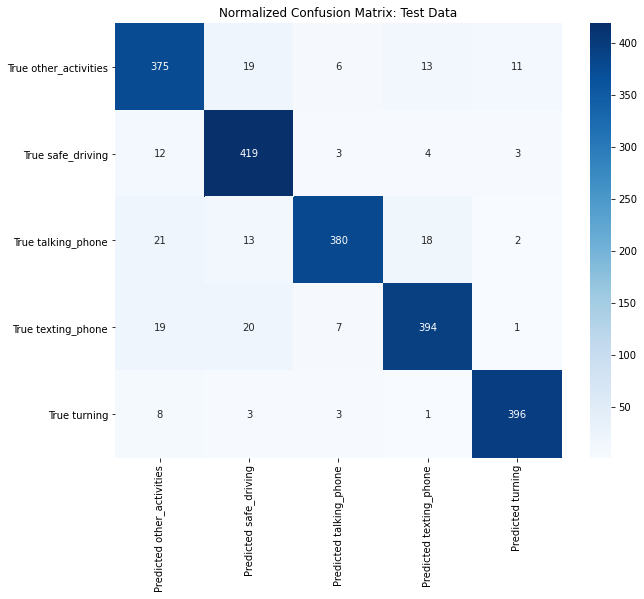

In [204]:
plotConfusionMatrix(MobileNet_3Layers)

**MobileNetV2 Confusion Matrix:**

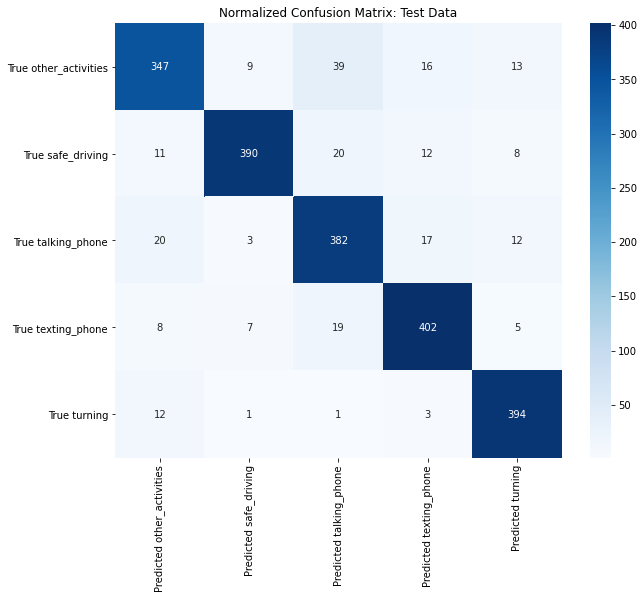

In [205]:
plotConfusionMatrix(MobileNetV2_3Layers)

Both model predicted the true positive values are pretty close. Either one is a reasonable choice.

Given the recall score and accuracy of MobileNet_3Layers is slight higher than the MobileNetV2_3Layers, we will choose MobileNet from now on.

Next step, we will try some other different hyperparameters see if we can get a better model:

In [334]:
## Create hyperparameters
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([ 256, 512]))

HP_NUM_UNITS2 = hp.HParam('num_units2', hp.Discrete([ 243, 452]))

HP_NUM_UNITS3 = hp.HParam('num_units3', hp.Discrete([ 321, 81]))

HP_NUM_LAYERS = hp.HParam('num_layers', hp.Discrete([1, 2, 3]))

HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))

HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([0.0001, 0.00001]))

HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

In [335]:
log_dir ='logs/fit' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
with tf.summary.create_file_writer(log_dir).as_default():
    hp.hparams_config(
    hparams=
    [HP_NUM_UNITS,HP_NUM_UNITS2,HP_NUM_UNITS3, HP_NUM_LAYERS, HP_DROPOUT,  HP_OPTIMIZER, HP_LEARNING_RATE],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

In [336]:
def create_model(hparams):
    pretrained = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape,pooling='max')
    
    for layer in pretrained.layers:
        layer.trainable=False

    #3. Instantiate the NN model 
    model = Sequential()

    # Add the pretrained layers 
    model.add(pretrained)
    
    for layer in pretrained.layers:
        layer.trainable=False
   
    for layers in range(1,hparams[HP_NUM_LAYERS]+1):
        print(f"\n******* layer = {layers}*******\n")
        if layers == 1:
            model.add(Dense(hparams[HP_NUM_UNITS],activation='relu'))
            model.add(Dropout(hparams[HP_DROPOUT]))
        elif layers == 2:
            model.add(Dense(hparams[HP_NUM_UNITS2],activation='relu'))
            model.add(Dropout(hparams[HP_DROPOUT]))
        elif layers == 3:
            model.add(Dense(hparams[HP_NUM_UNITS3],activation='relu'))
            model.add(Dropout(hparams[HP_DROPOUT]))
     
    
    # Adding output layer
    model.add(Dense(classes, activation='softmax'))
    
    optimizer = hparams[HP_OPTIMIZER]
    learning_rate = hparams[HP_LEARNING_RATE]
    
    if optimizer == "adam":
        optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "sgd":
        optimizer = tf.optimizers.SGD(learning_rate=learning_rate)
#     elif optimizer=='rmsprop':
#         optimizer = tf.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("unexpected optimizer name: %r" % (optimizer_name,))
        
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    #print(model.summary())

    history = model.fit_generator(
        generator = train_generator,steps_per_epoch = train_stepsize,
        validation_data=validation_generator,validation_steps=valid_stepsize,
        epochs = 10,verbose = 1) # Run with 1 epoch to speed things up for demo purposes
    
    accuracy = max(history.history["accuracy"])
    
    return history.history['val_accuracy'][-1]

In [337]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = create_model(hparams)
        #converting to tf scalar
        accuracy= tf.reshape(tf.convert_to_tensor(accuracy), []).numpy()
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)


In [338]:
session_num = 0
for num_layers in HP_NUM_LAYERS.domain.values:
    if num_layers == 1:
        for num_units in HP_NUM_UNITS.domain.values:
            for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
                        for optimizer in HP_OPTIMIZER.domain.values:
                            for learning_rate in HP_LEARNING_RATE.domain.values:
                                hparams = { HP_NUM_UNITS: num_units,
                                           HP_NUM_LAYERS: num_layers,
                                           HP_DROPOUT: dropout_rate,
                                           HP_OPTIMIZER: optimizer,
                                           HP_LEARNING_RATE: learning_rate,}
                                run_name = "run-%d" % session_num
                                print('\n-------------------------------')
                                print('--- Starting trial: %s' % run_name)
                                print({h.name: hparams[h] for h in hparams})
                                run('logs/hparam_tuning/' + run_name, hparams)
                                session_num += 1
                                print('-------------------------------\n')
            
    elif num_layers == 2:
        for num_units in HP_NUM_UNITS.domain.values:
            for num_units2 in HP_NUM_UNITS2.domain.values:
                for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
                        for optimizer in HP_OPTIMIZER.domain.values:
                            for learning_rate in HP_LEARNING_RATE.domain.values:
                                hparams = { HP_NUM_UNITS: num_units,
                                           HP_NUM_UNITS2: num_units2,
                                           HP_NUM_LAYERS: num_layers,
                                           HP_DROPOUT: dropout_rate,
                                           HP_OPTIMIZER: optimizer,
                                           HP_LEARNING_RATE: learning_rate,}
                                run_name = "run-%d" % session_num
                                print('\n-------------------------------')
                                print('--- Starting trial: %s' % run_name)
                                print({h.name: hparams[h] for h in hparams})
                                run('logs/hparam_tuning/' + run_name, hparams)
                                session_num += 1
                                print('-------------------------------\n')
                
    elif num_layers == 3:
        for num_units in HP_NUM_UNITS.domain.values:
            for num_units2 in HP_NUM_UNITS2.domain.values:
                for num_units3 in HP_NUM_UNITS3.domain.values:
                    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
                        for optimizer in HP_OPTIMIZER.domain.values:
                            for learning_rate in HP_LEARNING_RATE.domain.values:
                                hparams = { HP_NUM_UNITS: num_units,
                                           HP_NUM_UNITS2: num_units2,
                                           HP_NUM_UNITS3: num_units3,
                                           HP_NUM_LAYERS: num_layers,
                                           HP_DROPOUT: dropout_rate,
                                           HP_OPTIMIZER: optimizer,
                                           HP_LEARNING_RATE: learning_rate,}
                                run_name = "run-%d" % session_num
                                print('\n-------------------------------')
                                print('--- Starting trial: %s' % run_name)
                                print({h.name: hparams[h] for h in hparams})
                                run('logs/hparam_tuning/' + run_name, hparams)
                                session_num += 1
                                print('-------------------------------\n')
                                


-------------------------------
--- Starting trial: run-0
{'num_units': 256, 'num_layers': 1, 'dropout': 0.1, 'optimizer': 'adam', 'learning_rate': 1e-05}

******* layer = 1*******

Epoch 1/10
501/501 [==============================] - 33s 65ms/step - loss: 2.0984 - accuracy: 0.2451 - val_loss: 1.7717 - val_accuracy: 0.2850
Epoch 2/10
501/501 [==============================] - 32s 64ms/step - loss: 1.6369 - accuracy: 0.3577 - val_loss: 1.5142 - val_accuracy: 0.3871
Epoch 3/10
501/501 [==============================] - 32s 63ms/step - loss: 1.4271 - accuracy: 0.4325 - val_loss: 1.3548 - val_accuracy: 0.4653
Epoch 4/10
501/501 [==============================] - 32s 64ms/step - loss: 1.2525 - accuracy: 0.4976 - val_loss: 1.2368 - val_accuracy: 0.5179
Epoch 5/10
501/501 [==============================] - 31s 63ms/step - loss: 1.1327 - accuracy: 0.5532 - val_loss: 1.1516 - val_accuracy: 0.5592
Epoch 6/10
501/501 [==============================] - 31s 62ms/step - loss: 1.0285 - accuracy: 0.

501/501 [==============================] - 31s 61ms/step - loss: 0.5782 - accuracy: 0.8092 - val_loss: 0.7360 - val_accuracy: 0.7473
-------------------------------


-------------------------------
--- Starting trial: run-9
{'num_units': 512, 'num_layers': 1, 'dropout': 0.1, 'optimizer': 'adam', 'learning_rate': 0.0001}

******* layer = 1*******

Epoch 1/10
501/501 [==============================] - 31s 62ms/step - loss: 1.1152 - accuracy: 0.5655 - val_loss: 0.8397 - val_accuracy: 0.7231
Epoch 2/10
501/501 [==============================] - 30s 61ms/step - loss: 0.5211 - accuracy: 0.8233 - val_loss: 0.6581 - val_accuracy: 0.8033
Epoch 3/10
501/501 [==============================] - 31s 61ms/step - loss: 0.3383 - accuracy: 0.8980 - val_loss: 0.6183 - val_accuracy: 0.8236
Epoch 4/10
501/501 [==============================] - 31s 61ms/step - loss: 0.2408 - accuracy: 0.9356 - val_loss: 0.5482 - val_accuracy: 0.8528
Epoch 5/10
501/501 [==============================] - 31s 61ms/step - loss

501/501 [==============================] - 32s 65ms/step - loss: 0.0995 - accuracy: 0.9739 - val_loss: 0.5110 - val_accuracy: 0.8672
Epoch 9/10
501/501 [==============================] - 33s 66ms/step - loss: 0.0783 - accuracy: 0.9804 - val_loss: 0.5209 - val_accuracy: 0.8777
Epoch 10/10
501/501 [==============================] - 33s 65ms/step - loss: 0.0605 - accuracy: 0.9854 - val_loss: 0.5376 - val_accuracy: 0.8711
-------------------------------


-------------------------------
--- Starting trial: run-18
{'num_units': 256, 'num_units2': 243, 'num_layers': 2, 'dropout': 0.1, 'optimizer': 'sgd', 'learning_rate': 1e-05}

******* layer = 1*******


******* layer = 2*******

Epoch 1/10
501/501 [==============================] - 33s 65ms/step - loss: 2.1373 - accuracy: 0.1833 - val_loss: 1.9514 - val_accuracy: 0.1931
Epoch 2/10
501/501 [==============================] - 33s 65ms/step - loss: 1.9685 - accuracy: 0.1960 - val_loss: 1.8517 - val_accuracy: 0.2002
Epoch 3/10
501/501 [========


******* layer = 1*******


******* layer = 2*******

Epoch 1/10
501/501 [==============================] - 32s 65ms/step - loss: 2.4104 - accuracy: 0.1940 - val_loss: 1.9537 - val_accuracy: 0.1924
Epoch 2/10
501/501 [==============================] - 32s 64ms/step - loss: 2.3392 - accuracy: 0.1980 - val_loss: 1.9205 - val_accuracy: 0.1959
Epoch 3/10
501/501 [==============================] - 32s 65ms/step - loss: 2.3094 - accuracy: 0.1951 - val_loss: 1.8936 - val_accuracy: 0.2037
Epoch 4/10
501/501 [==============================] - 32s 65ms/step - loss: 2.2780 - accuracy: 0.1946 - val_loss: 1.8693 - val_accuracy: 0.2037
Epoch 5/10
501/501 [==============================] - 31s 62ms/step - loss: 2.2413 - accuracy: 0.2031 - val_loss: 1.8486 - val_accuracy: 0.2095
Epoch 6/10
501/501 [==============================] - 32s 64ms/step - loss: 2.2010 - accuracy: 0.2068 - val_loss: 1.8277 - val_accuracy: 0.2157
Epoch 7/10
501/501 [==============================] - 31s 62ms/step - loss: 2.1703

Epoch 10/10
501/501 [==============================] - 31s 62ms/step - loss: 1.8376 - accuracy: 0.2342 - val_loss: 1.6793 - val_accuracy: 0.2430
-------------------------------


-------------------------------
--- Starting trial: run-31
{'num_units': 256, 'num_units2': 452, 'num_layers': 2, 'dropout': 0.2, 'optimizer': 'sgd', 'learning_rate': 0.0001}

******* layer = 1*******


******* layer = 2*******

Epoch 1/10
501/501 [==============================] - 31s 61ms/step - loss: 1.9569 - accuracy: 0.2149 - val_loss: 1.6733 - val_accuracy: 0.2582
Epoch 2/10
501/501 [==============================] - 31s 62ms/step - loss: 1.8095 - accuracy: 0.2416 - val_loss: 1.5959 - val_accuracy: 0.2983
Epoch 3/10
501/501 [==============================] - 30s 60ms/step - loss: 1.7097 - accuracy: 0.2745 - val_loss: 1.5394 - val_accuracy: 0.3255
Epoch 4/10
501/501 [==============================] - 30s 60ms/step - loss: 1.6479 - accuracy: 0.2943 - val_loss: 1.4933 - val_accuracy: 0.3489
Epoch 5/10
501/5

Epoch 2/10
501/501 [==============================] - 31s 61ms/step - loss: 1.7438 - accuracy: 0.2658 - val_loss: 1.5875 - val_accuracy: 0.3232
Epoch 3/10
501/501 [==============================] - 31s 62ms/step - loss: 1.6159 - accuracy: 0.3131 - val_loss: 1.5059 - val_accuracy: 0.3750
Epoch 4/10
501/501 [==============================] - 31s 61ms/step - loss: 1.5295 - accuracy: 0.3544 - val_loss: 1.4392 - val_accuracy: 0.4151
Epoch 5/10
501/501 [==============================] - 31s 62ms/step - loss: 1.4599 - accuracy: 0.3973 - val_loss: 1.3847 - val_accuracy: 0.4463
Epoch 6/10
501/501 [==============================] - 31s 62ms/step - loss: 1.3934 - accuracy: 0.4209 - val_loss: 1.3350 - val_accuracy: 0.4751
Epoch 7/10
501/501 [==============================] - 31s 61ms/step - loss: 1.3463 - accuracy: 0.4495 - val_loss: 1.2960 - val_accuracy: 0.4945
Epoch 8/10
501/501 [==============================] - 32s 63ms/step - loss: 1.2906 - accuracy: 0.4786 - val_loss: 1.2614 - val_accuracy:

Epoch 7/10
501/501 [==============================] - 31s 61ms/step - loss: 1.4671 - accuracy: 0.3863 - val_loss: 1.3215 - val_accuracy: 0.4821
Epoch 8/10
501/501 [==============================] - 31s 62ms/step - loss: 1.4184 - accuracy: 0.4182 - val_loss: 1.2890 - val_accuracy: 0.4969
Epoch 9/10
501/501 [==============================] - 31s 62ms/step - loss: 1.3756 - accuracy: 0.4322 - val_loss: 1.2595 - val_accuracy: 0.5179
Epoch 10/10
501/501 [==============================] - 30s 61ms/step - loss: 1.3459 - accuracy: 0.4490 - val_loss: 1.2338 - val_accuracy: 0.5327
-------------------------------


-------------------------------
--- Starting trial: run-40
{'num_units': 512, 'num_units2': 452, 'num_layers': 2, 'dropout': 0.1, 'optimizer': 'adam', 'learning_rate': 1e-05}

******* layer = 1*******


******* layer = 2*******

Epoch 1/10
501/501 [==============================] - 35s 71ms/step - loss: 1.7029 - accuracy: 0.2928 - val_loss: 1.4203 - val_accuracy: 0.4042
Epoch 2/10
501/5


******* layer = 1*******


******* layer = 2*******

Epoch 1/10
501/501 [==============================] - 35s 70ms/step - loss: 1.8480 - accuracy: 0.2550 - val_loss: 1.4687 - val_accuracy: 0.3890
Epoch 2/10
501/501 [==============================] - 35s 71ms/step - loss: 1.5087 - accuracy: 0.3871 - val_loss: 1.2775 - val_accuracy: 0.4953
Epoch 3/10
501/501 [==============================] - 35s 70ms/step - loss: 1.3026 - accuracy: 0.4690 - val_loss: 1.1506 - val_accuracy: 0.5724
Epoch 4/10
501/501 [==============================] - 35s 70ms/step - loss: 1.1910 - accuracy: 0.5224 - val_loss: 1.0621 - val_accuracy: 0.6153
Epoch 5/10
501/501 [==============================] - 35s 70ms/step - loss: 1.0805 - accuracy: 0.5723 - val_loss: 0.9845 - val_accuracy: 0.6534
Epoch 6/10
501/501 [==============================] - 34s 67ms/step - loss: 0.9876 - accuracy: 0.6197 - val_loss: 0.9240 - val_accuracy: 0.6857
Epoch 7/10
501/501 [==============================] - 33s 67ms/step - loss: 0.8905

Epoch 9/10
501/501 [==============================] - 31s 62ms/step - loss: 1.2275 - accuracy: 0.4913 - val_loss: 1.1235 - val_accuracy: 0.5814
Epoch 10/10
501/501 [==============================] - 32s 63ms/step - loss: 1.1702 - accuracy: 0.5195 - val_loss: 1.0870 - val_accuracy: 0.6059
-------------------------------


-------------------------------
--- Starting trial: run-53
{'num_units': 256, 'num_units2': 243, 'num_units3': 81, 'num_layers': 3, 'dropout': 0.2, 'optimizer': 'adam', 'learning_rate': 0.0001}

******* layer = 1*******


******* layer = 2*******


******* layer = 3*******

Epoch 1/10
501/501 [==============================] - 32s 63ms/step - loss: 1.5233 - accuracy: 0.3635 - val_loss: 1.1395 - val_accuracy: 0.5635
Epoch 2/10
501/501 [==============================] - 31s 62ms/step - loss: 1.0800 - accuracy: 0.5676 - val_loss: 0.8861 - val_accuracy: 0.6916
Epoch 3/10
501/501 [==============================] - 32s 63ms/step - loss: 0.8185 - accuracy: 0.6821 - val_loss: 


******* layer = 1*******


******* layer = 2*******


******* layer = 3*******

Epoch 1/10
501/501 [==============================] - 32s 63ms/step - loss: 1.2551 - accuracy: 0.4813 - val_loss: 0.9102 - val_accuracy: 0.6885
Epoch 2/10
501/501 [==============================] - 31s 61ms/step - loss: 0.7305 - accuracy: 0.7290 - val_loss: 0.6954 - val_accuracy: 0.7804
Epoch 3/10
501/501 [==============================] - 31s 61ms/step - loss: 0.4878 - accuracy: 0.8235 - val_loss: 0.6176 - val_accuracy: 0.8115
Epoch 4/10
501/501 [==============================] - 31s 62ms/step - loss: 0.3303 - accuracy: 0.8812 - val_loss: 0.5891 - val_accuracy: 0.8322
Epoch 5/10
501/501 [==============================] - 32s 64ms/step - loss: 0.2330 - accuracy: 0.9221 - val_loss: 0.5778 - val_accuracy: 0.8450
Epoch 6/10
501/501 [==============================] - 32s 64ms/step - loss: 0.1720 - accuracy: 0.9439 - val_loss: 0.5501 - val_accuracy: 0.8598
Epoch 7/10
501/501 [==============================] - 3

501/501 [==============================] - 31s 62ms/step - loss: 0.5177 - accuracy: 0.8137 - val_loss: 0.6076 - val_accuracy: 0.8100
Epoch 5/10
501/501 [==============================] - 31s 61ms/step - loss: 0.3928 - accuracy: 0.8608 - val_loss: 0.5978 - val_accuracy: 0.8326
Epoch 6/10
501/501 [==============================] - 31s 63ms/step - loss: 0.3061 - accuracy: 0.8925 - val_loss: 0.5402 - val_accuracy: 0.8548
Epoch 7/10
501/501 [==============================] - 31s 62ms/step - loss: 0.2380 - accuracy: 0.9160 - val_loss: 0.5561 - val_accuracy: 0.8621
Epoch 8/10
501/501 [==============================] - 31s 62ms/step - loss: 0.1903 - accuracy: 0.9348 - val_loss: 0.5773 - val_accuracy: 0.8657
Epoch 9/10
501/501 [==============================] - 31s 61ms/step - loss: 0.1490 - accuracy: 0.9473 - val_loss: 0.5900 - val_accuracy: 0.8746
Epoch 10/10
501/501 [==============================] - 31s 62ms/step - loss: 0.1170 - accuracy: 0.9624 - val_loss: 0.6024 - val_accuracy: 0.8738
--

Epoch 8/10
501/501 [==============================] - 32s 63ms/step - loss: 0.0952 - accuracy: 0.9719 - val_loss: 0.5569 - val_accuracy: 0.8742
Epoch 9/10
501/501 [==============================] - 32s 64ms/step - loss: 0.0713 - accuracy: 0.9769 - val_loss: 0.5953 - val_accuracy: 0.8777
Epoch 10/10
501/501 [==============================] - 32s 63ms/step - loss: 0.0546 - accuracy: 0.9850 - val_loss: 0.6492 - val_accuracy: 0.8695
-------------------------------


-------------------------------
--- Starting trial: run-66
{'num_units': 256, 'num_units2': 452, 'num_units3': 81, 'num_layers': 3, 'dropout': 0.1, 'optimizer': 'sgd', 'learning_rate': 1e-05}

******* layer = 1*******


******* layer = 2*******


******* layer = 3*******

Epoch 1/10
501/501 [==============================] - 117s 233ms/step - loss: 1.9618 - accuracy: 0.1978 - val_loss: 1.7985 - val_accuracy: 0.1967
Epoch 2/10
501/501 [==============================] - 30s 61ms/step - loss: 1.9140 - accuracy: 0.1991 - val_loss: 


******* layer = 1*******


******* layer = 2*******


******* layer = 3*******

Epoch 1/10
501/501 [==============================] - 37s 74ms/step - loss: 2.0559 - accuracy: 0.2091 - val_loss: 1.7454 - val_accuracy: 0.2235
Epoch 2/10
501/501 [==============================] - 37s 73ms/step - loss: 2.0208 - accuracy: 0.2101 - val_loss: 1.7148 - val_accuracy: 0.2321
Epoch 3/10
501/501 [==============================] - 37s 73ms/step - loss: 1.9886 - accuracy: 0.2040 - val_loss: 1.6943 - val_accuracy: 0.2375
Epoch 4/10
501/501 [==============================] - 37s 73ms/step - loss: 1.9654 - accuracy: 0.2043 - val_loss: 1.6802 - val_accuracy: 0.2395
Epoch 5/10
501/501 [==============================] - 37s 73ms/step - loss: 1.9385 - accuracy: 0.2086 - val_loss: 1.6684 - val_accuracy: 0.2391
Epoch 6/10
501/501 [==============================] - 38s 75ms/step - loss: 1.9029 - accuracy: 0.2228 - val_loss: 1.6584 - val_accuracy: 0.2391
Epoch 7/10
501/501 [==============================] - 3

501/501 [==============================] - 34s 69ms/step - loss: 1.7684 - accuracy: 0.2109 - val_loss: 1.7025 - val_accuracy: 0.1776
Epoch 5/10
501/501 [==============================] - 34s 68ms/step - loss: 1.7578 - accuracy: 0.2021 - val_loss: 1.6917 - val_accuracy: 0.1861
Epoch 6/10
501/501 [==============================] - 34s 68ms/step - loss: 1.7381 - accuracy: 0.2119 - val_loss: 1.6827 - val_accuracy: 0.1943
Epoch 7/10
501/501 [==============================] - 35s 70ms/step - loss: 1.7287 - accuracy: 0.2109 - val_loss: 1.6772 - val_accuracy: 0.1970
Epoch 8/10
501/501 [==============================] - 34s 67ms/step - loss: 1.7248 - accuracy: 0.2234 - val_loss: 1.6700 - val_accuracy: 0.2021
Epoch 9/10
501/501 [==============================] - 34s 68ms/step - loss: 1.7235 - accuracy: 0.2169 - val_loss: 1.6638 - val_accuracy: 0.2068
Epoch 10/10
501/501 [==============================] - 34s 67ms/step - loss: 1.7152 - accuracy: 0.2178 - val_loss: 1.6589 - val_accuracy: 0.2079
--

501/501 [==============================] - 32s 64ms/step - loss: 1.7293 - accuracy: 0.2447 - val_loss: 1.6149 - val_accuracy: 0.2738
-------------------------------


-------------------------------
--- Starting trial: run-83
{'num_units': 512, 'num_units2': 243, 'num_units3': 81, 'num_layers': 3, 'dropout': 0.1, 'optimizer': 'sgd', 'learning_rate': 0.0001}

******* layer = 1*******


******* layer = 2*******


******* layer = 3*******

Epoch 1/10
501/501 [==============================] - 33s 67ms/step - loss: 1.8707 - accuracy: 0.2174 - val_loss: 1.6332 - val_accuracy: 0.2492
Epoch 2/10
501/501 [==============================] - 34s 67ms/step - loss: 1.6830 - accuracy: 0.2624 - val_loss: 1.5565 - val_accuracy: 0.3026
Epoch 3/10
501/501 [==============================] - 33s 66ms/step - loss: 1.5867 - accuracy: 0.3071 - val_loss: 1.5004 - val_accuracy: 0.3384
Epoch 4/10
501/501 [==============================] - 33s 66ms/step - loss: 1.5284 - accuracy: 0.3370 - val_loss: 1.4551 - val_


******* layer = 1*******


******* layer = 2*******


******* layer = 3*******

Epoch 1/10
501/501 [==============================] - 31s 63ms/step - loss: 2.0436 - accuracy: 0.2090 - val_loss: 1.6831 - val_accuracy: 0.2259
Epoch 2/10
501/501 [==============================] - 31s 62ms/step - loss: 1.8723 - accuracy: 0.2311 - val_loss: 1.6056 - val_accuracy: 0.2726
Epoch 3/10
501/501 [==============================] - 31s 62ms/step - loss: 1.7794 - accuracy: 0.2497 - val_loss: 1.5596 - val_accuracy: 0.3045
Epoch 4/10
501/501 [==============================] - 31s 63ms/step - loss: 1.7247 - accuracy: 0.2431 - val_loss: 1.5265 - val_accuracy: 0.3345
Epoch 5/10
501/501 [==============================] - 31s 63ms/step - loss: 1.6586 - accuracy: 0.2765 - val_loss: 1.4971 - val_accuracy: 0.3633
Epoch 6/10
501/501 [==============================] - 31s 62ms/step - loss: 1.6149 - accuracy: 0.2921 - val_loss: 1.4729 - val_accuracy: 0.3840
Epoch 7/10
501/501 [==============================] - 3

501/501 [==============================] - 32s 64ms/step - loss: 1.5559 - accuracy: 0.3143 - val_loss: 1.4622 - val_accuracy: 0.3781
Epoch 5/10
501/501 [==============================] - 32s 64ms/step - loss: 1.4992 - accuracy: 0.3480 - val_loss: 1.4263 - val_accuracy: 0.4167
Epoch 6/10
501/501 [==============================] - 32s 65ms/step - loss: 1.4751 - accuracy: 0.3620 - val_loss: 1.3930 - val_accuracy: 0.4439
Epoch 7/10
501/501 [==============================] - 66s 131ms/step - loss: 1.4278 - accuracy: 0.3969 - val_loss: 1.3641 - val_accuracy: 0.4611
Epoch 8/10
501/501 [==============================] - 41s 81ms/step - loss: 1.3989 - accuracy: 0.4089 - val_loss: 1.3334 - val_accuracy: 0.4790
Epoch 9/10
501/501 [==============================] - 63s 125ms/step - loss: 1.3618 - accuracy: 0.4287 - val_loss: 1.3080 - val_accuracy: 0.4930
Epoch 10/10
501/501 [==============================] - 43s 85ms/step - loss: 1.3451 - accuracy: 0.4425 - val_loss: 1.2839 - val_accuracy: 0.5078


-------------------------------


-------------------------------
--- Starting trial: run-100
{'num_units': 512, 'num_units2': 452, 'num_units3': 81, 'num_layers': 3, 'dropout': 0.2, 'optimizer': 'adam', 'learning_rate': 1e-05}

******* layer = 1*******


******* layer = 2*******


******* layer = 3*******

Epoch 1/10
501/501 [==============================] - 108s 217ms/step - loss: 1.9898 - accuracy: 0.2224 - val_loss: 1.5426 - val_accuracy: 0.3228
Epoch 2/10
501/501 [==============================] - 31s 61ms/step - loss: 1.6441 - accuracy: 0.3059 - val_loss: 1.4230 - val_accuracy: 0.4155
Epoch 3/10
501/501 [==============================] - 31s 63ms/step - loss: 1.5089 - accuracy: 0.3507 - val_loss: 1.3381 - val_accuracy: 0.4708
Epoch 4/10
501/501 [==============================] - 31s 61ms/step - loss: 1.3966 - accuracy: 0.4212 - val_loss: 1.2513 - val_accuracy: 0.5343
Epoch 5/10
501/501 [==============================] - 31s 61ms/step - loss: 1.3187 - accuracy: 0.4533 - val_loss:

501/501 [==============================] - 38s 76ms/step - loss: 1.3024 - accuracy: 0.4632 - val_loss: 1.1667 - val_accuracy: 0.5732
Epoch 5/10
501/501 [==============================] - 38s 77ms/step - loss: 1.2041 - accuracy: 0.5069 - val_loss: 1.0999 - val_accuracy: 0.5958
Epoch 6/10
501/501 [==============================] - 38s 76ms/step - loss: 1.1105 - accuracy: 0.5522 - val_loss: 1.0264 - val_accuracy: 0.6328
Epoch 7/10
501/501 [==============================] - 38s 77ms/step - loss: 1.0319 - accuracy: 0.5898 - val_loss: 0.9726 - val_accuracy: 0.6507
Epoch 8/10
501/501 [==============================] - 39s 77ms/step - loss: 0.9743 - accuracy: 0.6195 - val_loss: 0.9222 - val_accuracy: 0.6671
Epoch 9/10
501/501 [==============================] - 38s 76ms/step - loss: 0.9229 - accuracy: 0.6373 - val_loss: 0.8878 - val_accuracy: 0.6768
Epoch 10/10
501/501 [==============================] - 38s 76ms/step - loss: 0.8556 - accuracy: 0.6648 - val_loss: 0.8552 - val_accuracy: 0.6881
--

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

%tensorboard --logdir 'logs/hparam_tuning'

Reusing TensorBoard on port 6006 (pid 23272), started 3 days, 14:51:11 ago. (Use '!kill 23272' to kill it.)

![title](./tensorboard.png)

After the grid search of tensorflow, it gives the parameters with the best accuracy as above.

Let's build a new model based on this report:

1. Load the MobileNet benchmark model:

In [211]:
MobileNet_Benchmark = tf.keras.models.load_model('saved_model/MobileNet_Benchmark')

2. Set layer parameters and compile:

In [212]:
# Define parameters, default learning rate is 0.0001
new_layers = [512, 0.2, 452, 0.2, 321, 0.2]
MobileNet_TensorBoard = addLayers2Model_compile(MobileNet_Benchmark,new_layers)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 1024)              3228864   
_________________________________________________________________
dense_83 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_44 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_84 (Dense)             (None, 452)               231876    
_________________________________________________________________
dropout_45 (Dropout)         (None, 452)               0         
_________________________________________________________________
dense_85 (Dense)             (None, 321)               145413    
_________________________________________________________________
dropout_46 (Dropout)         (None, 321)             

3. Train and evaluate model:

Epoch 1/10
501/501 [==============================] - 73s 145ms/step - loss: 1.2987 - accuracy: 0.4690 - val_loss: 0.8723 - val_accuracy: 0.6947
Epoch 2/10
501/501 [==============================] - 73s 145ms/step - loss: 0.7521 - accuracy: 0.7065 - val_loss: 0.6254 - val_accuracy: 0.8057
Epoch 3/10
501/501 [==============================] - 71s 142ms/step - loss: 0.4835 - accuracy: 0.8233 - val_loss: 0.5303 - val_accuracy: 0.8474
Epoch 4/10
501/501 [==============================] - 73s 146ms/step - loss: 0.3350 - accuracy: 0.8825 - val_loss: 0.5471 - val_accuracy: 0.8586
Epoch 5/10
501/501 [==============================] - 74s 147ms/step - loss: 0.2224 - accuracy: 0.9208 - val_loss: 0.4894 - val_accuracy: 0.8762
Epoch 6/10
501/501 [==============================] - 76s 152ms/step - loss: 0.1629 - accuracy: 0.9464 - val_loss: 0.4899 - val_accuracy: 0.8910
Epoch 7/10
501/501 [==============================] - 75s 150ms/step - loss: 0.1266 - accuracy: 0.9571 - val_loss: 0.5395 - val_ac

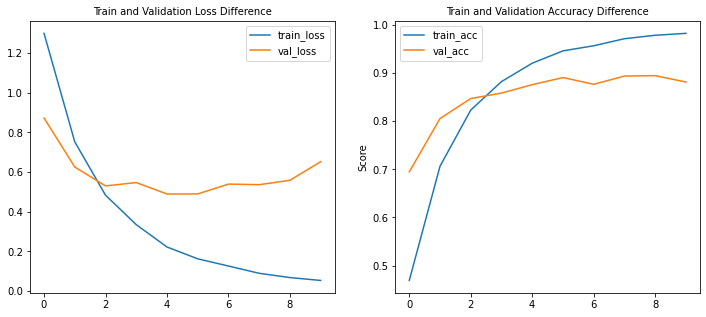

Classification Report
 
                   precision    recall  f1-score   support

other_activities       0.95      0.78      0.85       424
    safe_driving       0.95      0.93      0.94       441
   talking_phone       0.81      0.96      0.88       434
   texting_phone       0.93      0.92      0.92       441
         turning       0.94      0.96      0.95       411

        accuracy                           0.91      2151
       macro avg       0.91      0.91      0.91      2151
    weighted avg       0.91      0.91      0.91      2151



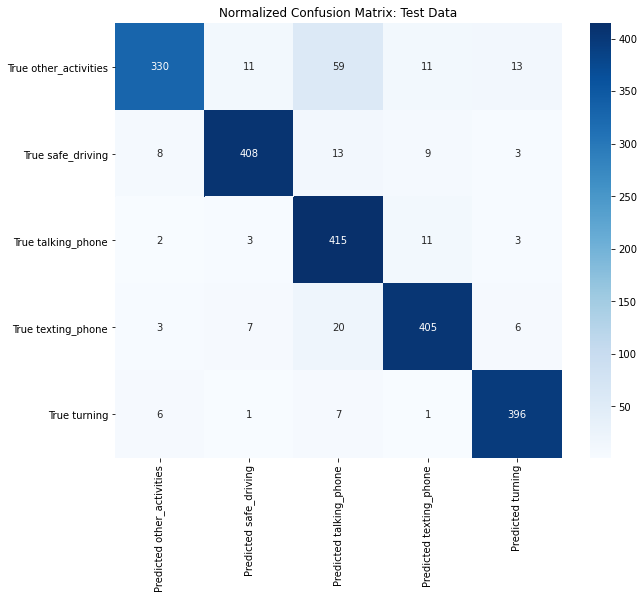

In [214]:
MobileNet_TensorBoard =  model_Fit_Evaluate(MobileNet_TensorBoard,10)

4. Save model:

In [216]:
MobileNet_TensorBoard[0].save('saved_model/MobileNet_TensorBoard')

INFO:tensorflow:Assets written to: saved_model/MobileNet_TensorBoard\assets


5. Load model:

In [26]:
MobileNet_TensorBoard = tf.keras.models.load_model('saved_model/MobileNet_TensorBoard')

6. Get classification report:

In [218]:
printClassificationReport(MobileNet_TensorBoard)

Prediction Time: 17 seconds.

Classification Report
 
                   precision    recall  f1-score   support

other_activities       0.95      0.78      0.85       424
    safe_driving       0.95      0.93      0.94       441
   talking_phone       0.81      0.96      0.88       434
   texting_phone       0.93      0.92      0.92       441
         turning       0.94      0.96      0.95       411

        accuracy                           0.91      2151
       macro avg       0.91      0.91      0.91      2151
    weighted avg       0.91      0.91      0.91      2151



Accuracy:

In [43]:
MobileNet_TensorBoard.evaluate_generator(
    test_generator, steps=test_stepsize, callbacks=None, max_queue_size=10, workers=1,
    use_multiprocessing=False, verbose=1
)

179/179 [==============================] - 8s 42ms/step - loss: 0.4073 - accuracy: 0.9083


[0.4073188304901123, 0.9082867503166199]

Compare with previous MobileNet 3 Layers model:

In [220]:
printClassificationReport(MobileNet_3Layers)

Prediction Time: 16 seconds.

Classification Report
 
                   precision    recall  f1-score   support

other_activities       0.86      0.88      0.87       424
    safe_driving       0.88      0.95      0.92       441
   talking_phone       0.95      0.88      0.91       434
   texting_phone       0.92      0.89      0.90       441
         turning       0.96      0.96      0.96       411

        accuracy                           0.91      2151
       macro avg       0.91      0.91      0.91      2151
    weighted avg       0.91      0.91      0.91      2151



7. Plot confusion matrix:

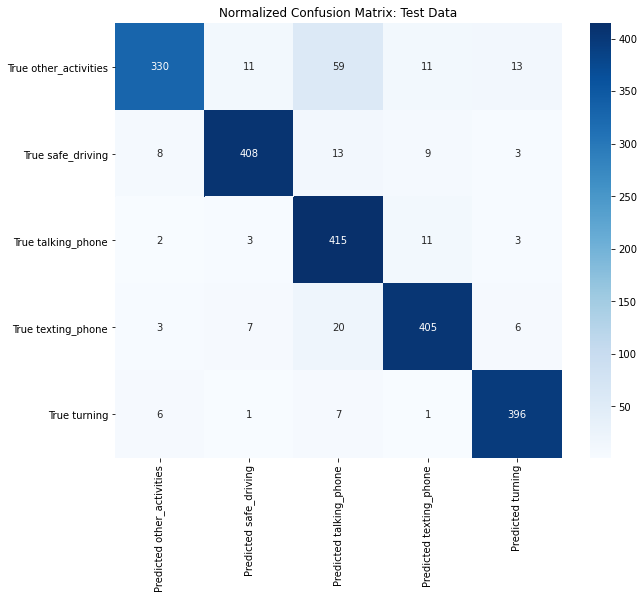

In [219]:
plotConfusionMatrix(MobileNet_TensorBoard)

Compare with MobileNet_3Layers confusion matrix:

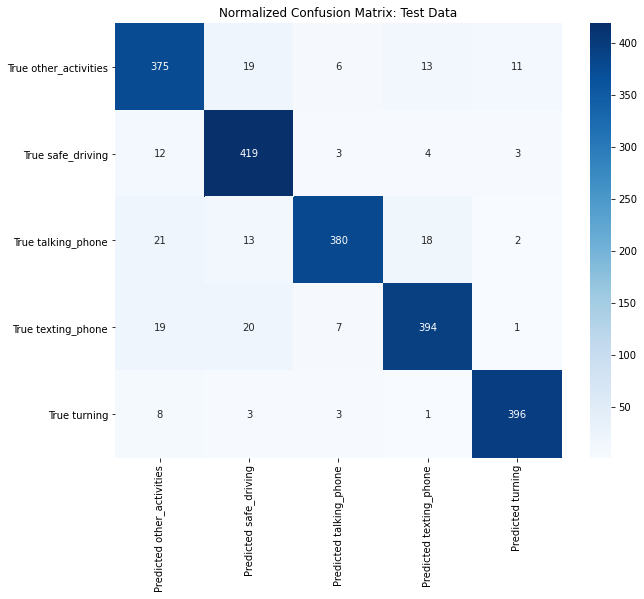

In [221]:
plotConfusionMatrix(MobileNet_3Layers)

The new model misclassified more `other_activities` to `talking_phone` categories and misclassified more to other activities.

Our new model got some improvement on the new parameters, but the accuracy (90.8%) is less than the MobileNet_3Layers(91.4%).

Let's see if we can get any improvement if we augment the training images:

In [266]:
# Instantiating the train generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split = 0.3,
                                  rotation_range=20,
                                  zoom_range=0.15,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.15,
                                  horizontal_flip=True,
                                  fill_mode="nearest")

# Instantiating the test generator
test_datagen = ImageDataGenerator(rescale=1./255)

In [267]:
train_generator,validation_generator, test_generator = imgGeneator()


train_stepsize = train_generator.samples // train_generator.batch_size 
valid_stepsize = validation_generator.samples // validation_generator.batch_size 
test_stepsize = test_generator.samples // test_generator.batch_size 

print(f'\r\nTraining Sample Size:\t{train_generator.samples}\tBatch Size: {train_generator.batch_size}\tStep Size: {train_stepsize}\r\n')
print(f'Validation Sample Size:\t{validation_generator.samples}\tBatch Size: {validation_generator.batch_size}\tStep Size: {valid_stepsize}\r\n')
print(f'Test Sample Size:\t{test_generator.samples}\tBatch Size: {test_generator.batch_size}\tStep Size: {test_stepsize}\r\n')

Found 6023 images belonging to 5 classes.
Found 2577 images belonging to 5 classes.
Found 2151 images belonging to 5 classes.

Training Sample Size:	6023	Batch Size: 12	Step Size: 501

Validation Sample Size:	2577	Batch Size: 12	Step Size: 214

Test Sample Size:	2151	Batch Size: 12	Step Size: 179



Show Train Set:

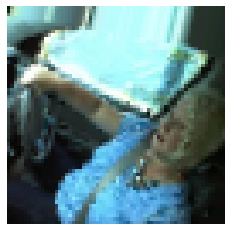

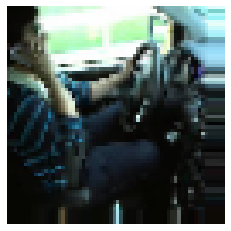

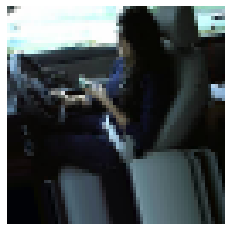

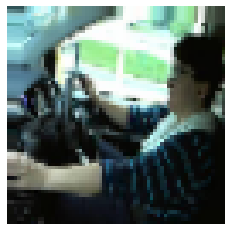

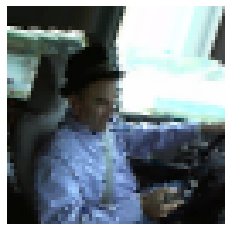

In [268]:
showGeneratorImage(train_generator,5)

Show Test Set:

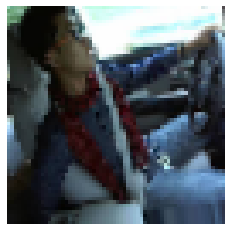

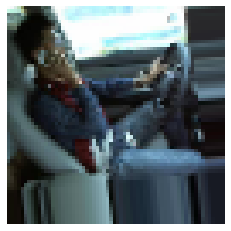

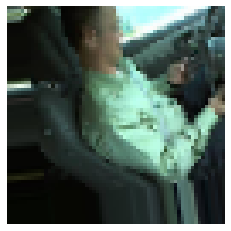

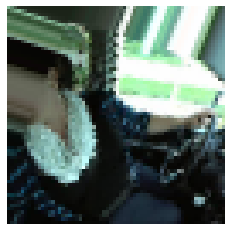

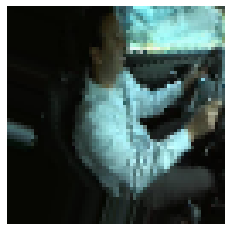

In [245]:
showGeneratorImage(test_generator,5)

In [246]:
MobileNet_Benchmark = tf.keras.models.load_model('saved_model/MobileNet_Benchmark')
new_layers = [512, 0.2, 452, 0.2, 321, 0.2]
MobileNet_TensorBoard_AUG = addLayers2Model_compile(MobileNet_Benchmark,new_layers)

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 1024)              3228864   
_________________________________________________________________
dense_95 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_53 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_96 (Dense)             (None, 452)               231876    
_________________________________________________________________
dropout_54 (Dropout)         (None, 452)               0         
_________________________________________________________________
dense_97 (Dense)             (None, 321)               145413    
_________________________________________________________________
dropout_55 (Dropout)         (None, 321)             

Epoch 1/10
501/501 [==============================] - 78s 156ms/step - loss: 1.6321 - accuracy: 0.2795 - val_loss: 1.4361 - val_accuracy: 0.3797
Epoch 2/10
501/501 [==============================] - 74s 148ms/step - loss: 1.4361 - accuracy: 0.3760 - val_loss: 1.3503 - val_accuracy: 0.4248
Epoch 3/10
501/501 [==============================] - 78s 155ms/step - loss: 1.3464 - accuracy: 0.4339 - val_loss: 1.2852 - val_accuracy: 0.4599
Epoch 4/10
501/501 [==============================] - 75s 150ms/step - loss: 1.2979 - accuracy: 0.4487 - val_loss: 1.2532 - val_accuracy: 0.4840
Epoch 5/10
501/501 [==============================] - 72s 144ms/step - loss: 1.2676 - accuracy: 0.4603 - val_loss: 1.2129 - val_accuracy: 0.5043
Epoch 6/10
501/501 [==============================] - 72s 144ms/step - loss: 1.2322 - accuracy: 0.4806 - val_loss: 1.2188 - val_accuracy: 0.4887
Epoch 7/10
501/501 [==============================] - 77s 154ms/step - loss: 1.2073 - accuracy: 0.4904 - val_loss: 1.1878 - val_ac

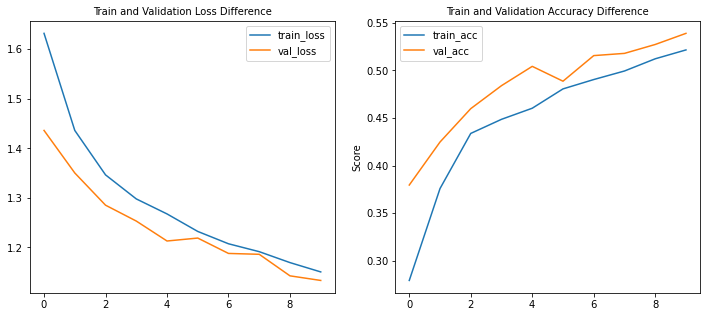

Classification Report
 
                   precision    recall  f1-score   support

other_activities       0.48      0.43      0.45       424
    safe_driving       0.79      0.49      0.60       441
   talking_phone       0.48      0.55      0.51       434
   texting_phone       0.48      0.70      0.57       441
         turning       0.94      0.83      0.88       411

        accuracy                           0.60      2151
       macro avg       0.63      0.60      0.60      2151
    weighted avg       0.63      0.60      0.60      2151



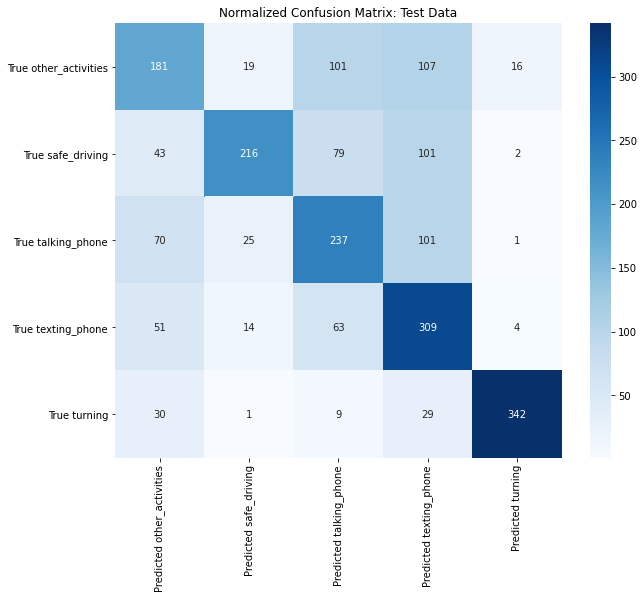

In [247]:
MobileNet_TensorBoard_AUG =  model_Fit_Evaluate(MobileNet_TensorBoard_AUG,10)

In [ ]:
MobileNet_TensorBoard_AUG[0].save('saved_model/MobileNet_TensorBoard_AUG')

In [27]:
MobileNet_TensorBoard_AUG = tf.keras.models.load_model('saved_model/MobileNet_TensorBoard_AUG')

In [46]:
MobileNet_TensorBoard_AUG.evaluate_generator(
    test_generator, steps=test_stepsize, callbacks=None, max_queue_size=10, workers=1,
    use_multiprocessing=False, verbose=1
)

179/179 [==============================] - 8s 44ms/step - loss: 1.0092 - accuracy: 0.5973


[1.0091966390609741, 0.5972998142242432]

As we can see the output is even worse when we train our model with augmented images.

If we re-train our pre-trained MobileNet TensorBoard Model:

In [30]:
MobileNet_TensorBoard_Pretrained_AUG = tf.keras.models.load_model('saved_model/MobileNet_TensorBoard')

Epoch 1/10
501/501 [==============================] - 247s 493ms/step - loss: 2.6687 - accuracy: 0.3370 - val_loss: 1.3684 - val_accuracy: 0.4276
Epoch 2/10
501/501 [==============================] - 248s 496ms/step - loss: 1.3879 - accuracy: 0.4092 - val_loss: 1.2304 - val_accuracy: 0.4833
Epoch 3/10
501/501 [==============================] - 257s 514ms/step - loss: 1.2491 - accuracy: 0.4748 - val_loss: 1.1419 - val_accuracy: 0.5284
Epoch 4/10
501/501 [==============================] - 256s 511ms/step - loss: 1.1184 - accuracy: 0.5339 - val_loss: 1.0037 - val_accuracy: 0.5997
Epoch 5/10
501/501 [==============================] - 249s 497ms/step - loss: 1.0097 - accuracy: 0.5888 - val_loss: 0.9214 - val_accuracy: 0.6371
Epoch 6/10
501/501 [==============================] - 241s 481ms/step - loss: 0.9319 - accuracy: 0.6308 - val_loss: 0.8553 - val_accuracy: 0.6982
Epoch 7/10
501/501 [==============================] - 248s 495ms/step - loss: 0.8657 - accuracy: 0.6684 - val_loss: 0.7487 -

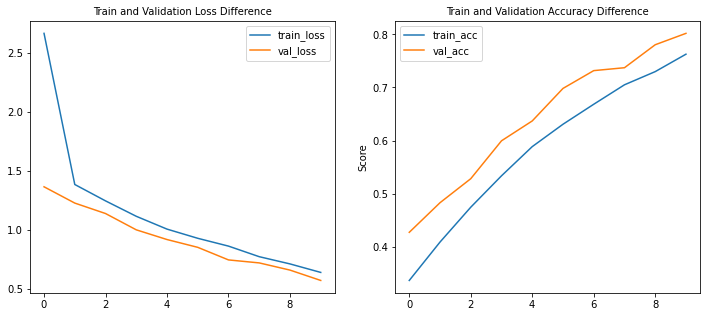

Classification Report
 
                   precision    recall  f1-score   support

other_activities       0.90      0.57      0.70       424
    safe_driving       0.85      0.93      0.89       441
   talking_phone       0.73      0.85      0.79       434
   texting_phone       0.87      0.94      0.91       441
         turning       0.93      0.95      0.94       411

        accuracy                           0.85      2151
       macro avg       0.86      0.85      0.84      2151
    weighted avg       0.86      0.85      0.84      2151



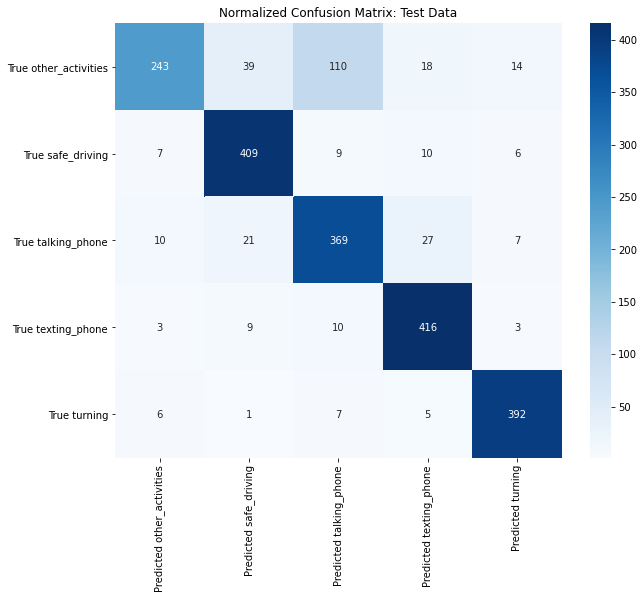

In [250]:
MobileNet_TensorBoard_Pretrained_AUG =  model_Fit_Evaluate(MobileNet_TensorBoard_Pretrained_AUG,10)

In [48]:
MobileNet_TensorBoard_Pretrained_AUG.evaluate_generator(
    test_generator, steps=test_stepsize, callbacks=None, max_queue_size=10, workers=1,
    use_multiprocessing=False, verbose=1
)

179/179 [==============================] - 7s 41ms/step - loss: 0.4073 - accuracy: 0.9083


[0.4073188304901123, 0.9082867503166199]

The accuracy is still not as good as MobileNet_3Layer (91.4% accuracy).

In [ ]:
MobileNet_TensorBoard_Pretrained_AUG[0].save('saved_model/MobileNet_TensorBoard_Pretrained_AUG')

In [28]:
MobileNet_TensorBoard_Pretrained_AUG = tf.keras.models.load_model('saved_model/MobileNet_TensorBoard_Pretrained_AUG')

In [33]:
#MobileNet_TensorBoard = tf.keras.models.load_model('saved_model/MobileNet_TensorBoard')

At this point, we decide to user MobileNet_3Layers as our final model:

Final Model Layout:

In [138]:
# Read Becnmark model
MobileNet_Benchmark = tf.keras.models.load_model('saved_model/MobileNet_Benchmark')

# Define layers, integer indicates neuron number, decimal indicates dropout rate
new_layers = [243, 0.15, 243, 0.15, 81]


MobileNet_3Layers = addLayers2Model_compile(MobileNet_Benchmark,new_layers)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 1024)              3228864   
_________________________________________________________________
dense_4 (Dense)              (None, 243)               249075    
_________________________________________________________________
dropout_3 (Dropout)          (None, 243)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 243)               59292     
_________________________________________________________________
dropout_4 (Dropout)          (None, 243)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 81)                19764     
_________________________________________________________________
dense_7 (Dense)              (None, 5)                

Restore the images:

In [35]:
# Instantiating the train generator
train_datagen = ImageDataGenerator(rescale=1./255,validation_split = 0.3)

# Instantiating the test generator
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator,validation_generator, test_generator = imgGeneator()

train_stepsize = train_generator.samples // train_generator.batch_size 
valid_stepsize = validation_generator.samples // validation_generator.batch_size 
test_stepsize = test_generator.samples // test_generator.batch_size 

print(f'\r\nTraining Sample Size:\t{train_generator.samples}\tBatch Size: {train_generator.batch_size}\tStep Size: {train_stepsize}\r\n')
print(f'Validation Sample Size:\t{validation_generator.samples}\tBatch Size: {validation_generator.batch_size}\tStep Size: {valid_stepsize}\r\n')
print(f'Test Sample Size:\t{test_generator.samples}\tBatch Size: {test_generator.batch_size}\tStep Size: {test_stepsize}\r\n')

Found 6023 images belonging to 5 classes.
Found 2577 images belonging to 5 classes.
Found 2151 images belonging to 5 classes.

Training Sample Size:	6023	Batch Size: 12	Step Size: 501

Validation Sample Size:	2577	Batch Size: 12	Step Size: 214

Test Sample Size:	2151	Batch Size: 12	Step Size: 179



Predict on some random selections on the test set for each category:

This image most likely belongs to 'talking_phone' with a 71.63 % probability.


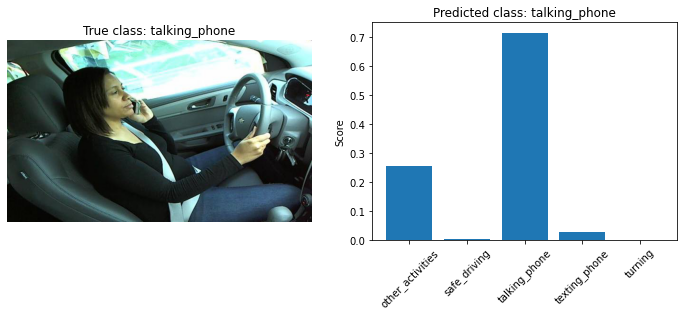

In [27]:
predicOnPicture(MobileNet_3Layers)

This image most likely belongs to 'safe_driving' with a 87.42 % probability.


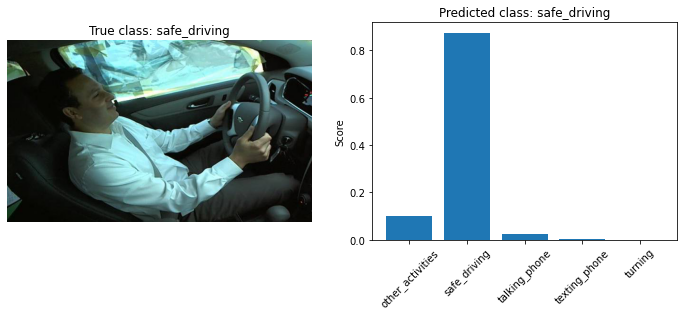

In [30]:
predicOnPicture(MobileNet_3Layers)

This image most likely belongs to 'talking_phone' with a 98.55 % probability.


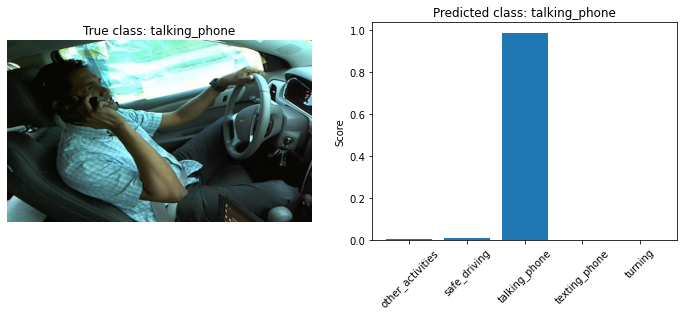

In [31]:
predicOnPicture(MobileNet_3Layers)

This image most likely belongs to 'texting_phone' with a 96.34 % probability.


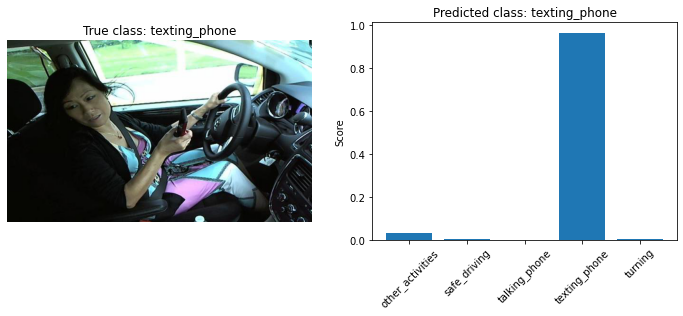

In [35]:
predicOnPicture(MobileNet_3Layers)

This image most likely belongs to 'turning' with a 92.28 % probability.


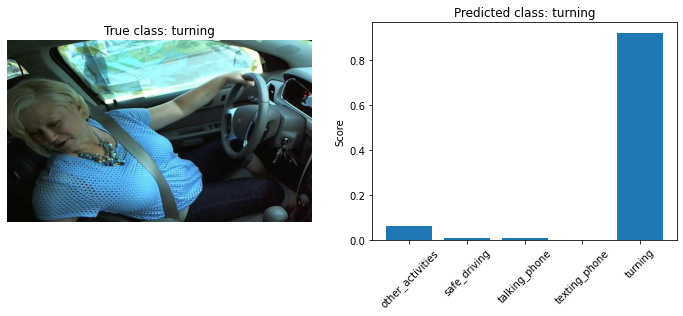

In [36]:
predicOnPicture(MobileNet_3Layers)

This image most likely belongs to 'turning' with a 99.26 % probability.


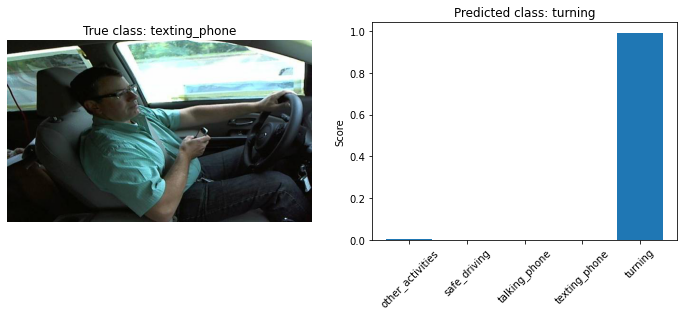

In [32]:
predicOnPicture(MobileNet_3Layers)

This image most likely belongs to 'turning' with a 78.53 % probability.


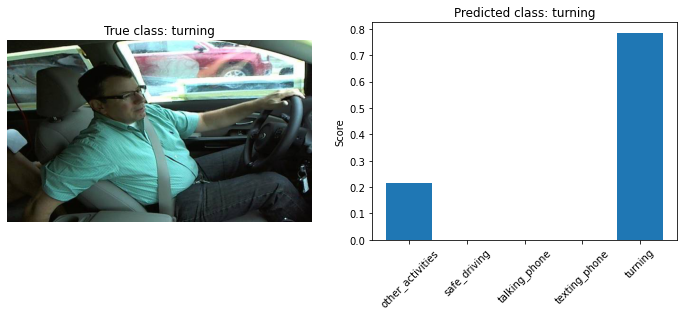

In [43]:
predicOnPicture(MobileNet_3Layers)

This image most likely belongs to 'other_activities' with a 99.46 % probability.


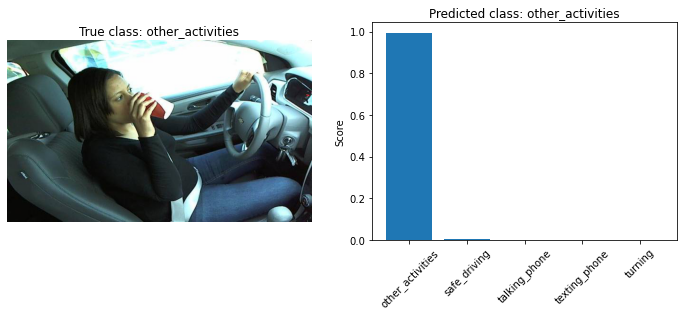

In [42]:
predicOnPicture(MobileNet_3Layers)

This image most likely belongs to 'turning' with a 99.96 % probability.


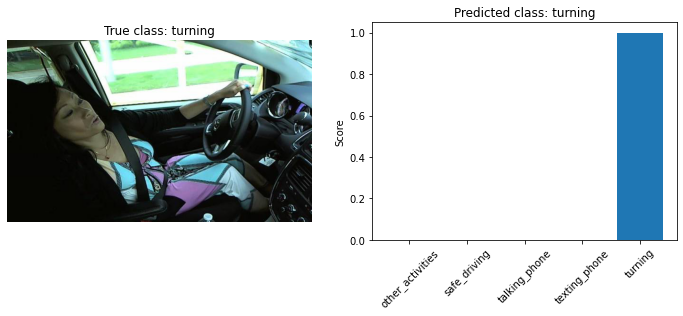

In [32]:
predicOnPicture(MobileNet_3Layers)

---

Predict on the Video:

In [34]:
predictVideo(MobileNet_3Layers,test_generator)

cleaning up...
Done.
